# * TOL Performance *

## Note :

#### Responsible :
- K.Sakolporn Hanchanlert (K.Horn)
- Online & Convergence
- sakolporn_han@truecorp.co.th

#### Issue :
- ตัวเลขที่ BU รายงานไม่ตรงกับ VINSIGHT
- BU จะมากกว่า เพราะมีการ manual adjustment บางส่วนที่เป็น external ไม่เข้าระบบ

#### Solving :
- ต้องหา solution ที่จะ sync data กลุ่ม manual adjust ให้เข้าระบบ VINSIGHT
- พี่ตี๋เสนอว่า ทุกสิ้นเดือนจะ replace data จาก Finance(ทุกสิ้นเดือนยอดจะพุ่ง)

#### Other :
- Actual Source: มากจาก DWH
- Target เป็นตัวเลขมุม Finance(รวมถึงตัวเลขที่มีการ adjustment)
- Save Rate: ลูกค้ายกเลิก แล้วเรา Save ได้ แต่คุ้มกับ Cost ไหม ?

## Import Data Source

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import configparser
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from functools import reduce

mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

In [2]:
''' Config '''

config = configparser.ConfigParser()
config.read('../../my_config.ini')
config.sections()
as_week = config['PARAM']['as_week']
v_product = 'TOL'

In [3]:
data_src = f"../../data/raw/Raw-Agg Perf Nationwide_Wk {as_week}.csv"
df = pd.read_csv(data_src, low_memory=False)
cols = ['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 
        'ACTUAL_AS_OF', 'AGG_TYPE', 'RR_IND', 'GRY_IND', 'UOM', 'PERIOD', 'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG', 'BASELINE_SNAP', 'BASELINE_AGG', 'PPN_TM']
df = df[cols]

''' Fix Metric CD List '''
tol_rev_cd_list = ['TB3R000100CORP', 'TB3R000101CORP', 'TB3R000102CORP'] # 'TOL Revenue', 'TOL New Revenue', 'TOL Existing Revenue'
tol_sale_cd_list = ['TB3S000101', 'TB3S000100', 'TB3R000600'] # 'TOL Gross Add - Registration Subs', 'TOL Gross Add - Connected Subs', 'TOL Connected Inflow M1'
tol_sub_cd_list = ['TB3S000400', 'TB3S000500', 'TSER13100'] # 'TOL Net Add', 'TOL Active Subs', 'TOL Churn Subs'
tol_all_cd_list = tol_rev_cd_list + tol_sale_cd_list + tol_sub_cd_list

In [4]:
df.shape

(135282, 24)

In [5]:
''' Find Metric '''

df_agg_s = df[df['AGG_TYPE']=='S'].groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE', 'GRY_IND'])\
    .agg({'ACTUAL_SNAP': 'sum', 'ACTUAL_AGG': 'sum', 'TARGET_SNAP': 'sum', 'TARGET_AGG': 'sum', 'BASELINE_SNAP':'sum', 'BASELINE_AGG':'sum', 'TM_KEY_DAY':'max'}).reset_index()
# df_agg_n = df.loc[df[(df['AGG_TYPE']=='N') & (df['ACTUAL_SNAP']>0)].groupby('METRIC_CD')['TM_KEY_DAY'].idxmax()].reset_index()
df_agg_n = df.loc[df[df['AGG_TYPE']=='N'].groupby('METRIC_CD')['TM_KEY_DAY'].idxmax()].reset_index()
df_agg_n = df_agg_n[['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE', 'GRY_IND', 
                     'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG', 'BASELINE_SNAP', 'BASELINE_AGG', 'TM_KEY_DAY']]
df_metric = pd.concat([df_agg_s, df_agg_n])
df_metric = df_metric.rename(columns={'TM_KEY_DAY':'MAX_DAY'})
df_metric['ACTUAL_SNAP'] = df_metric['ACTUAL_SNAP'] / 1000000
df_metric['ACTUAL_AGG'] = df_metric['ACTUAL_AGG'] / 1000000
df_metric['TARGET_SNAP'] = df_metric['TARGET_SNAP'] / 1000000
df_metric['TARGET_AGG'] = df_metric['TARGET_AGG'] / 1000000
df_metric['BASELINE_SNAP'] = df_metric['BASELINE_SNAP'] / 1000000
df_metric['BASELINE_AGG'] = df_metric['BASELINE_AGG'] / 1000000
# df_metric

''' Filters '''
# df_tmp = df_metric[df_metric['PRODUCT_GRP']=="TOL"]
# df_tmp = df_tmp[df_tmp['CENTER']=="Sales & Revenue"]
# df_tmp = df_tmp[df_tmp['METRIC_GRP']=="Revenue"]
# df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Revenue")]
# df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Sub")]
df_tmp = df_metric[df_metric['METRIC_CD'].isin(tol_all_cd_list)]
df_tmp = df_tmp.sort_values(by=['CENTER', 'METRIC_GRP', 'COMP_CD', 'METRIC_CD']).reset_index()

# df_tmp.to_excel('TOL_Metric.xlsx', index=False)
df_tmp

,index,CENTER,METRIC_GRP,COMP_CD,PRODUCT_GRP,METRIC_CD,METRIC_NAME,AGG_TYPE,GRY_IND,ACTUAL_SNAP,ACTUAL_AGG,TARGET_SNAP,TARGET_AGG,BASELINE_SNAP,BASELINE_AGG,MAX_DAY
0,34,Revenue,Retention & Churn,TRUE,TOL,TSER13100,TOL Churn Subs,S,RYG,0.335778,5.616371,0.312257,4.967884,0.399168,6.344928,20231029
1,82,Revenue,Revenue,TRUE,TOL,TB3R000100CORP,TOL Revenue,S,GYR,11421.082310,185438.354244,12068.654910,195731.789492,0.000000,0.000000,20231029
2,84,Revenue,Revenue,TRUE,TOL,TB3R000101CORP,TOL New Revenue,S,GYR,1273.991693,21249.079529,1606.352328,26146.483851,0.000000,0.000000,20231029
3,86,Revenue,Revenue,TRUE,TOL,TB3R000102CORP,TOL Existing Revenue,S,GYR,10145.370206,164163.649124,10462.302581,169585.305641,0.000000,0.000000,20231029
4,204,Revenue,Sales,TRUE,TOL,TB3R000600,TOL Connected Inflow M1,S,GYR,206.581096,3257.364981,257.998403,4065.741468,0.000000,0.000000,20231029
5,215,Revenue,Sales,TRUE,TOL,TB3S000100,TOL Gross Add - Connected Subs,S,GYR,0.341432,5.442550,0.496451,7.826663,0.000000,0.000000,20231029
6,226,Revenue,Sales,TRUE,TOL,TB3S000101,TOL Gross Add - Registration Subs,S,GYR,0.413972,6.714628,0.000000,0.000000,0.000000,0.000000,20231029
7,278,Revenue,Subs,TRUE,TOL,TB3S000400,TOL Net Add,S,GYR,0.001728,-0.185473,0.179658,2.845171,-0.399168,-6.344928,20231029
8,86,Revenue,Subs,TRUE,TOL,TB3S000500,TOL Active Subs,N,GYR,3.067252,3.067252,3.368280,3.368280,0.000000,0.000000,20231029


## Data Preporation

In [6]:
''' Functions '''

def unit_mb(baht):
    n = baht
    unit_mb = n / 1000000
    return unit_mb

def unit_k(baht):
    n = baht
    unit_k = n / 1000
    return unit_k

In [7]:
''' Rawdata '''

''' Filters '''
# df = df[df['TM_KEY_MTH'] <= 202309] # MONTH filter
# df = df[df['TM_KEY_WK'] <= 2023029] # WEEK filter
# df = df[df['TM_KEY_DAY'] <= 20230714] # DAY filter
df = df[df['METRIC_CD'].isin(tol_all_cd_list)]

''' Modify '''
df = df.rename(columns={'ACTUAL_SNAP':'ACT_SNAP', 'ACTUAL_AGG':'ACT_AGG', 'TARGET_SNAP':'TGT_SNAP', 'TARGET_AGG':'TGT_AGG', 'BASELINE_SNAP':'BL_SNAP', 'BASELINE_AGG':'BL_AGG'})

''' Add new column '''
df['MTH_DESC'] = pd.to_datetime(df['TM_KEY_MTH'], format='%Y%m', errors='coerce').dt.strftime('%B')
df['WK_LABEL'] = df['TM_KEY_WK'].apply(str).str[5:].astype(int)
df['DAY_LABEL'] = df['TM_KEY_DAY'].apply(str).str[6:].astype(int)

df.tail(3)

,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,CENTER,METRIC_GRP,COMP_CD,PRODUCT_GRP,METRIC_CD,...,ACT_SNAP,ACT_AGG,TGT_SNAP,TGT_AGG,BL_SNAP,BL_AGG,PPN_TM,MTH_DESC,WK_LABEL,DAY_LABEL
113895,20231027,2023043,202310,20234,2023,Revenue,Revenue,TRUE,TOL,TB3R000100CORP,...,NaN,1.389162e+09,NaN,1.392466e+09,NaN,0.0,2023-10-30 06:53:12,October,43,27
113896,20231028,2023043,202310,20234,2023,Revenue,Revenue,TRUE,TOL,TB3R000100CORP,...,NaN,1.389162e+09,NaN,1.392466e+09,NaN,0.0,2023-10-30 06:53:12,October,43,28
113897,20231029,2023043,202310,20234,2023,Revenue,Revenue,TRUE,TOL,TB3R000100CORP,...,NaN,1.389162e+09,NaN,1.392466e+09,NaN,0.0,2023-10-30 06:53:12,October,43,29


In [8]:
''' Create Dataframe '''

''' Aggregate type : S '''
df_agg_s = df[df['AGG_TYPE']=='S']
df_agg_s = df_agg_s.rename(columns={'ACT_SNAP':'ACT', 'TGT_SNAP':'TGT', 'BL_SNAP':'BL'})

''' Aggregate type : N '''
df_agg_n = df[df['AGG_TYPE']=='N'].dropna(subset='ACT_SNAP')
df_agg_n = df_agg_n.rename(columns={'ACT_SNAP':'ACT', 'TGT_SNAP':'TGT', 'BL_SNAP':'BL'})

In [9]:
''' Period Values '''

curr_yr = df['TM_KEY_YR'].max()
last_yr = df['TM_KEY_YR'].max() - 1
curr_mth = df['TM_KEY_MTH'].max()
curr_mth_desc = pd.to_datetime(curr_mth, format='%Y%m', errors='coerce').strftime('%B')
last_mth = int(f'{str(last_yr)}12') if str(curr_mth)[4:]=='01' else curr_mth-1
curr_wk = df['TM_KEY_WK'].max()
last_wk = df['TM_KEY_WK'].drop_duplicates().shift().max()
curr_wk_label = df['WK_LABEL'].iloc[-1]
curr_day = df['TM_KEY_DAY'].max()
last_day = df['TM_KEY_DAY'].drop_duplicates().shift().max()
curr_day_label = df['DAY_LABEL'].iloc[-1]
last_ppn_tm = df['PPN_TM'].max()

wk_day_start = int(str(df[df['TM_KEY_WK']==curr_wk]['TM_KEY_DAY'].min())[6:])
wk_day_end = int(str(df[df['TM_KEY_WK']==curr_wk]['TM_KEY_DAY'].max())[6:])

### DAY : Aggregation (base level)

In [10]:
''' Create Dataframe '''

cols_agg = ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC', 'DAY_LABEL', 
            'AGG_TYPE', 'GRY_IND', 'ACT_SNAP', 'ACT_AGG', 'TGT_SNAP', 'TGT_AGG', 'BL_SNAP', 'BL_AGG']
df_day = df[cols_agg].reset_index()

''' Aggregation '''
df_day['ACT'] = np.where(df_day['AGG_TYPE']=='N', df_day['ACT_AGG'], df_day['ACT_SNAP'])
df_day['TGT'] = np.where(df_day['AGG_TYPE']=='N', df_day['TGT_AGG'], df_day['TGT_SNAP'])
# df_day['%ACHV'] = df_day['ACT'] / df_day['TGT']
df_day['%ACHV'] = np.where(df_day['METRIC_NAME'].str.contains("Churn"), -((df_day['ACT']/df_day['TGT'])-1), df_day['ACT']/df_day['TGT']) 
df_day['GAP'] = df_day['ACT'] - df_day['TGT']
df_day['LAST_ACT'] = df_day.groupby('METRIC_CD')['ACT'].shift()
df_day['DIFF'] = df_day['ACT'] - df_day['LAST_ACT']
df_day['%DOD'] = (df_day['ACT'] / df_day['LAST_ACT']) - 1

# df_day.to_excel('df_day.xlsx', index=False)
df_day.tail(3)

,index,METRIC_CD,METRIC_NAME,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,MTH_DESC,DAY_LABEL,...,TGT_AGG,BL_SNAP,BL_AGG,ACT,TGT,%ACHV,GAP,LAST_ACT,DIFF,%DOD
2184,113895,TB3R000100CORP,TOL Revenue,20231027,2023043,202310,20234,2023,October,27,...,1.392466e+09,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2185,113896,TB3R000100CORP,TOL Revenue,20231028,2023043,202310,20234,2023,October,28,...,1.392466e+09,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2186,113897,TB3R000100CORP,TOL Revenue,20231029,2023043,202310,20234,2023,October,29,...,1.392466e+09,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
''' Fix Columns Dict '''

cols_dict = {'TOL Revenue':'TOTAL', 'TOL New Revenue':'NEW', 'TOL Existing Revenue':'EXIST', 
             'TOL Gross Add - Connected Subs':'CON_SUB', 'TOL Gross Add - Registration Subs':'REG_SUB', 'TOL Connected Inflow M1':'M1', 
             'TOL Net Add':'NET_ADD', 'TOL Active Subs':'ACTV_SUB', 'TOL Churn Subs':'CHRN_SUB'}


In [12]:
''' Pivot by KPIS '''

df_day_agg = df_day.pivot(index=['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC', 'DAY_LABEL'], columns='METRIC_NAME', 
                          values=['ACT', 'TGT', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%DOD']).rename(columns=cols_dict).reset_index()
df_day_agg.tail(3)

TM_KEY_DAY TM_KEY_WK TM_KEY_MTH TM_KEY_QTR TM_KEY_YR MTH_DESC  \
METRIC_NAME                                                                 
240           20231027   2023043     202310      20234      2023  October   
241           20231028   2023043     202310      20234      2023  October   
242           20231029   2023043     202310      20234      2023  October   

            DAY_LABEL        ACT                     ...  DIFF      %DOD  \
METRIC_NAME             ACTV_SUB CHRN_SUB        M1  ... TOTAL  ACTV_SUB   
240                27  3055483.0      NaN  761028.0  ...   NaN -0.000306   
241                28  3065746.0      NaN  799343.0  ...   NaN  0.003359   
242                29  3067252.0      NaN       NaN  ...   NaN  0.000491   

                                                                            
METRIC_NAME CHRN_SUB        M1 EXIST   CON_SUB   REG_SUB NET_ADD NEW TOTAL  
240              NaN  0.040520   NaN  0.081914  0.022110     NaN NaN   NaN  
241              NaN  0.050346   NaN  0.018741 -0.090853     NaN NaN   NaN  
242              NaN       NaN   NaN       NaN       NaN     NaN NaN   NaN  

[3 rows x 70 columns]

## ** Yearly **

### YR : Aggregation

In [13]:
''' Create Dataframe '''

df_agg_s_yr = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR', 'AGG_TYPE']).agg({'ACT': 'sum', 'TGT': 'sum'}).reset_index()
df_agg_n_yr = df_agg_n.loc[df_agg_n.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR', 'AGG_TYPE', 'ACT', 'TGT']]
df_yr = pd.concat([df_agg_s_yr, df_agg_n_yr])

''' Aggregation '''
df_yr['%ACHV'] = np.where(df_yr['METRIC_NAME'].str.contains("Churn"), -((df_yr['ACT']/df_yr['TGT'])-1), df_yr['ACT']/df_yr['TGT']) 
df_yr['GAP'] = df_yr['ACT'] - df_yr['TGT']
df_yr['LAST_ACT'] = df_yr.groupby('METRIC_CD')['ACT'].shift()
df_yr['DIFF'] = df_yr['ACT'] - df_yr['LAST_ACT']
df_yr['%YOY'] = (df_yr['ACT'] / df_yr['LAST_ACT']) - 1

df_yr#.tail()

,METRIC_CD,METRIC_NAME,TM_KEY_YR,AGG_TYPE,ACT,TGT,%ACHV,GAP,LAST_ACT,DIFF,%YOY
0,TB3R000100CORP,TOL Revenue,2023,S,1.142108e+10,1.206865e+10,0.946343,-6.475726e+08,NaN,NaN,NaN
1,TB3R000101CORP,TOL New Revenue,2023,S,1.273992e+09,1.606352e+09,0.793096,-3.323606e+08,NaN,NaN,NaN
2,TB3R000102CORP,TOL Existing Revenue,2023,S,1.014537e+10,1.046230e+10,0.969707,-3.169324e+08,NaN,NaN,NaN
3,TB3R000600,TOL Connected Inflow M1,2023,S,2.065811e+08,2.579984e+08,0.800707,-5.141731e+07,NaN,NaN,NaN
4,TB3S000100,TOL Gross Add - Connected Subs,2023,S,3.414320e+05,4.964510e+05,0.687746,-1.550190e+05,NaN,NaN,NaN
5,TB3S000101,TOL Gross Add - Registration Subs,2023,S,4.139720e+05,0.000000e+00,inf,4.139720e+05,NaN,NaN,NaN
6,TB3S000400,TOL Net Add,2023,S,1.728000e+03,1.796580e+05,0.009618,-1.779300e+05,NaN,NaN,NaN
7,TSER13100,TOL Churn Subs,2023,S,3.357780e+05,3.122570e+05,-0.075326,2.352100e+04,NaN,NaN,NaN
101261,TB3S000500,TOL Active Subs,2023,N,3.067252e+06,3.368280e+06,0.910629,-3.010280e+05,NaN,NaN,NaN


In [14]:
''' Pivot by KPIS '''

df_yr_agg = df_yr.pivot(index='TM_KEY_YR', columns='METRIC_NAME', 
                        values=['ACT', 'TGT', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%YOY']).rename(columns=cols_dict).reset_index()
df_yr_agg.tail(3)

TM_KEY_YR        ACT                                        \
METRIC_NAME             ACTV_SUB  CHRN_SUB            M1         EXIST   
0                2023  3067252.0  335778.0  2.065811e+08  1.014537e+10   

                                                                     ...  \
METRIC_NAME   CON_SUB   REG_SUB NET_ADD           NEW         TOTAL  ...   
0            341432.0  413972.0  1728.0  1.273992e+09  1.142108e+10  ...   

             DIFF     %YOY                                                 \
METRIC_NAME TOTAL ACTV_SUB CHRN_SUB  M1 EXIST CON_SUB REG_SUB NET_ADD NEW   
0             NaN      NaN      NaN NaN   NaN     NaN     NaN     NaN NaN   

                   
METRIC_NAME TOTAL  
0             NaN  

[1 rows x 64 columns]

In [15]:
''' YTD Values '''

day_cnt_curr_yr = len(df_day_agg[df_day_agg['TM_KEY_YR']==curr_yr]['TM_KEY_DAY'].unique())
day_cnt_last_yr = len(df_day_agg[df_day_agg['TM_KEY_YR']==last_yr]['TM_KEY_DAY'].unique())

''' Last Period : Values '''
last_yr_rev = df_yr_agg[df_yr_agg['TM_KEY_YR']==last_yr]['ACT']['TOTAL'].sum()
last_yr_rev_new = df_yr_agg[df_yr_agg['TM_KEY_YR']==last_yr]['ACT']['NEW'].sum()
last_yr_rev_exist = df_yr_agg[df_yr_agg['TM_KEY_YR']==last_yr]['ACT']['EXIST'].sum()
last_yr_actv_sub = df_yr_agg[df_yr_agg['TM_KEY_YR']==last_yr]['ACT']['ACTV_SUB'].sum()
last_yr_con_sub = df_yr_agg[df_yr_agg['TM_KEY_YR']==last_yr]['ACT']['CON_SUB'].sum()
last_yr_reg_sub = df_yr_agg[df_yr_agg['TM_KEY_YR']==last_yr]['ACT']['REG_SUB'].sum()
last_yr_chrn_sub = df_yr_agg[df_yr_agg['TM_KEY_YR']==last_yr]['ACT']['CHRN_SUB'].sum()
last_yr_net_add = df_yr_agg[df_yr_agg['TM_KEY_YR']==last_yr]['ACT']['NET_ADD'].sum()
last_yr_m1 = df_yr_agg[df_yr_agg['TM_KEY_YR']==last_yr]['ACT']['M1'].sum()

''' TOTAL : Values '''
ytd_rev = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['TOTAL'].sum()
ytd_tgt = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['TOTAL'].sum()
ytd_achv = ytd_rev / ytd_tgt
ytd_last_rev = (last_yr_rev / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy = (ytd_rev / ytd_last_rev) - 1
ytd_gap = ytd_rev - ytd_last_rev

''' NEW : Values '''
ytd_rev_new = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['NEW'].sum()
ytd_tgt_new = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['NEW'].sum()
ytd_achv_new = ytd_rev_new / ytd_tgt_new
ytd_last_rev_new = (last_yr_rev_new / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy_new = (ytd_rev_new / ytd_last_rev_new) - 1
ytd_gap_new = ytd_rev_new - ytd_last_rev_new

''' EXIST : Values '''
ytd_rev_exist = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['EXIST'].sum()
ytd_tgt_exist = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['EXIST'].sum()
ytd_achv_exist = ytd_rev_exist / ytd_tgt_exist
ytd_last_rev_exist = (last_yr_rev_exist / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy_exist = (ytd_rev_exist / ytd_last_rev_exist) - 1
ytd_gap_exist = ytd_rev_exist - ytd_last_rev_exist

''' ACTV_SUB : Values '''
ytd_actv_sub = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['ACTV_SUB'].sum()
ytd_tgt_actv_sub = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['ACTV_SUB'].sum()
ytd_achv_actv_sub = ytd_actv_sub / ytd_tgt_actv_sub
ytd_last_actv_sub = (last_yr_actv_sub / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy_actv_sub = (ytd_actv_sub / ytd_last_actv_sub) - 1
ytd_gap_actv_sub = ytd_actv_sub - ytd_last_actv_sub

''' CON_SUB : Values '''
ytd_con_sub = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['CON_SUB'].sum()
ytd_tgt_con_sub = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['CON_SUB'].sum()
ytd_achv_con_sub = ytd_con_sub / ytd_tgt_con_sub
ytd_last_con_sub = (last_yr_con_sub / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy_con_sub = (ytd_con_sub / ytd_last_con_sub) - 1
ytd_gap_con_sub = ytd_con_sub - ytd_last_con_sub

''' REG_SUB : Values '''
ytd_reg_sub = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['REG_SUB'].sum()
ytd_tgt_reg_sub = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['REG_SUB'].sum()
ytd_achv_reg_sub = ytd_reg_sub / ytd_tgt_reg_sub
ytd_last_reg_sub = (last_yr_reg_sub / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy_reg_sub = (ytd_reg_sub / ytd_last_reg_sub) - 1
ytd_gap_reg_sub = ytd_reg_sub - ytd_last_reg_sub

''' CHRN_SUB : Values '''
ytd_chrn_sub = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['CHRN_SUB'].sum()
ytd_tgt_chrn_sub = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['CHRN_SUB'].sum()
ytd_achv_chrn_sub = -((ytd_chrn_sub / ytd_tgt_chrn_sub) - 1)
ytd_last_chrn_sub = (last_yr_chrn_sub / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy_chrn_sub = (ytd_chrn_sub / ytd_last_chrn_sub) - 1
ytd_gap_chrn_sub = ytd_chrn_sub - ytd_last_chrn_sub

''' NET_ADD : Values '''
ytd_net_add = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['NET_ADD'].sum()
ytd_tgt_net_add = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['NET_ADD'].sum()
ytd_achv_net_add = ytd_net_add / ytd_tgt_net_add
ytd_last_net_add = (last_yr_net_add / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy_net_add = (ytd_net_add / ytd_last_net_add) - 1
ytd_gap_net_add = ytd_net_add - ytd_last_net_add

''' M1 : Values '''
ytd_m1 = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['M1'].sum()
ytd_tgt_m1 = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['M1'].sum()
ytd_achv_m1 = ytd_m1 / ytd_tgt_m1
ytd_last_m1 = (last_yr_m1 / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy_m1 = (ytd_m1 / ytd_last_m1) - 1
ytd_gap_m1 = ytd_m1 - ytd_last_m1

C:\Users\Narut4\AppData\Local\Temp\ipykernel_33120\3322964059.py:21: RuntimeWarning: invalid value encountered in scalar divide
  ytd_last_rev = (last_yr_rev / day_cnt_last_yr) * day_cnt_curr_yr
C:\Users\Narut4\AppData\Local\Temp\ipykernel_33120\3322964059.py:29: RuntimeWarning: invalid value encountered in scalar divide
  ytd_last_rev_new = (last_yr_rev_new / day_cnt_last_yr) * day_cnt_curr_yr
C:\Users\Narut4\AppData\Local\Temp\ipykernel_33120\3322964059.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ytd_last_rev_exist = (last_yr_rev_exist / day_cnt_last_yr) * day_cnt_curr_yr
C:\Users\Narut4\AppData\Local\Temp\ipykernel_33120\3322964059.py:45: RuntimeWarning: invalid value encountered in scalar divide
  ytd_last_actv_sub = (last_yr_actv_sub / day_cnt_last_yr) * day_cnt_curr_yr
C:\Users\Narut4\AppData\Local\Temp\ipykernel_33120\3322964059.py:53: RuntimeWarning: invalid value encountered in scalar divide
  ytd_last_con_sub = (last_yr_con_sub / day_cnt_last_yr) * day

In [16]:
''' YTD BarH Dataframe'''

df_bar_h_ytd = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['ACT'][['CON_SUB', 'REG_SUB', 'CHRN_SUB', 'NET_ADD']].T.reset_index()
df_bar_h_ytd.columns = ['METRIC_NAME', 'VALUES']

color_conditions = [df_bar_h_ytd['METRIC_NAME']=='REG_SUB', 
                    df_bar_h_ytd['METRIC_NAME']=='CON_SUB', 
                    df_bar_h_ytd['METRIC_NAME']=='CHRN_SUB', 
                    df_bar_h_ytd['METRIC_NAME']=='NET_ADD',]
color_results = ['royalblue', 'limegreen', 'lightcoral', 'gold']
sort_results = [1, 2, 3, 4]

df_bar_h_ytd['COLOR'] = np.select(color_conditions, color_results)
df_bar_h_ytd['SORT_NO'] = np.select(color_conditions, sort_results)

df_bar_h_ytd = df_bar_h_ytd.sort_values(by='SORT_NO', ascending=False)
df_bar_h_ytd

,METRIC_NAME,VALUES,COLOR,SORT_NO
3,NET_ADD,1728.0,gold,4
2,CHRN_SUB,335778.0,lightcoral,3
0,CON_SUB,341432.0,limegreen,2
1,REG_SUB,413972.0,royalblue,1


In [17]:
''' Year Chart Values '''

x_yr = df_yr_agg['TM_KEY_YR']
x_yr_axis = np.arange(len(x_yr))

''' TOTAL : Values '''
y_yr_act = df_yr_agg['ACT']['TOTAL']
y_yr_tgt = df_yr_agg['TGT']['TOTAL']
y_yr_achv = df_yr_agg['%ACHV']['TOTAL']
y_yr_gap = df_yr_agg['GAP']['TOTAL']
y_yr_diff = df_yr_agg['DIFF']['TOTAL']
y_yr_last_act = df_yr_agg['LAST_ACT']['TOTAL']
y_yr_yoy = df_yr_agg['%YOY']['TOTAL']

''' NEW : Values '''
y_yr_act_new = df_yr_agg['ACT']['NEW']
y_yr_tgt_new = df_yr_agg['TGT']['NEW']
y_yr_achv_new = df_yr_agg['%ACHV']['NEW']
y_yr_gap_new = df_yr_agg['GAP']['NEW']
y_yr_diff_new = df_yr_agg['DIFF']['NEW']
y_yr_last_act_new = df_yr_agg['LAST_ACT']['NEW']
y_yr_yoy_new = df_yr_agg['%YOY']['NEW']

''' EXIST : Values '''
y_yr_act_exist = df_yr_agg['ACT']['EXIST']
y_yr_tgt_exist = df_yr_agg['TGT']['EXIST']
y_yr_achv_exist = df_yr_agg['%ACHV']['EXIST']
y_yr_gap_exist = df_yr_agg['GAP']['EXIST']
y_yr_diff_exist = df_yr_agg['DIFF']['EXIST']
y_yr_last_act_exist = df_yr_agg['LAST_ACT']['EXIST']
y_yr_yoy_exist = df_yr_agg['%YOY']['EXIST']

''' ACTV_SUB : Values '''
y_yr_act_actv_sub = df_yr_agg['ACT']['ACTV_SUB']
y_yr_tgt_actv_sub = df_yr_agg['TGT']['ACTV_SUB']
y_yr_achv_actv_sub = df_yr_agg['%ACHV']['ACTV_SUB']
y_yr_gap_actv_sub = df_yr_agg['GAP']['ACTV_SUB']
y_yr_diff_actv_sub = df_yr_agg['DIFF']['ACTV_SUB']
y_yr_last_act_actv_sub = df_yr_agg['LAST_ACT']['ACTV_SUB']
y_yr_yoy_actv_sub = df_yr_agg['%YOY']['ACTV_SUB']

''' CON_SUB : Values '''
y_yr_act_con_sub = df_yr_agg['ACT']['CON_SUB']
y_yr_tgt_con_sub = df_yr_agg['TGT']['CON_SUB']
y_yr_achv_con_sub = df_yr_agg['%ACHV']['CON_SUB']
y_yr_gap_con_sub = df_yr_agg['GAP']['CON_SUB']
y_yr_diff_con_sub = df_yr_agg['DIFF']['CON_SUB']
y_yr_last_act_con_sub = df_yr_agg['LAST_ACT']['CON_SUB']
y_yr_yoy_con_sub = df_yr_agg['%YOY']['CON_SUB']

''' REG_SUB : Values '''
y_yr_act_reg_sub = df_yr_agg['ACT']['REG_SUB']
y_yr_tgt_reg_sub = df_yr_agg['TGT']['REG_SUB']
y_yr_achv_reg_sub = df_yr_agg['%ACHV']['REG_SUB']
y_yr_gap_reg_sub = df_yr_agg['GAP']['REG_SUB']
y_yr_diff_reg_sub = df_yr_agg['DIFF']['REG_SUB']
y_yr_last_act_reg_sub = df_yr_agg['LAST_ACT']['REG_SUB']
y_yr_yoy_reg_sub = df_yr_agg['%YOY']['REG_SUB']

''' CHRN_SUB : Values '''
y_yr_act_chrn_sub = df_yr_agg['ACT']['CHRN_SUB']
y_yr_tgt_chrn_sub = df_yr_agg['TGT']['CHRN_SUB']
y_yr_achv_chrn_sub = df_yr_agg['%ACHV']['CHRN_SUB']
y_yr_gap_chrn_sub = df_yr_agg['GAP']['CHRN_SUB']
y_yr_diff_chrn_sub = df_yr_agg['DIFF']['CHRN_SUB']
y_yr_last_act_chrn_sub = df_yr_agg['LAST_ACT']['CHRN_SUB']
y_yr_yoy_chrn_sub = df_yr_agg['%YOY']['CHRN_SUB']

''' NET_ADD : Values '''
y_yr_act_net_add = df_yr_agg['ACT']['NET_ADD']
y_yr_tgt_net_add = df_yr_agg['TGT']['NET_ADD']
y_yr_achv_net_add = df_yr_agg['%ACHV']['NET_ADD']
y_yr_gap_net_add = df_yr_agg['GAP']['NET_ADD']
y_yr_diff_net_add = df_yr_agg['DIFF']['NET_ADD']
y_yr_last_act_net_add = df_yr_agg['LAST_ACT']['NET_ADD']
y_yr_yoy_net_add = df_yr_agg['%YOY']['NET_ADD']

''' M1 : Values '''
y_yr_act_m1 = df_yr_agg['ACT']['M1']
y_yr_tgt_m1 = df_yr_agg['TGT']['M1']
y_yr_achv_m1 = df_yr_agg['%ACHV']['M1']
y_yr_gap_m1 = df_yr_agg['GAP']['M1']
y_yr_diff_m1 = df_yr_agg['DIFF']['M1']
y_yr_last_act_m1 = df_yr_agg['LAST_ACT']['M1']
y_yr_yoy_m1 = df_yr_agg['%YOY']['M1']

### YR : Visualizations

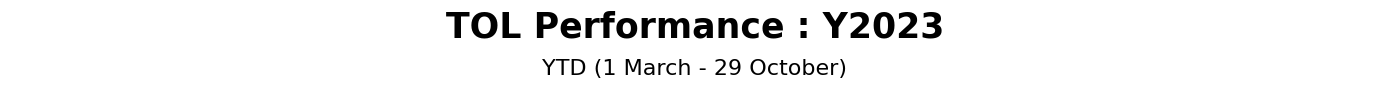

In [18]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"{v_product} Performance : Y{curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"YTD (1 March - {curr_day_label} {curr_mth_desc})", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

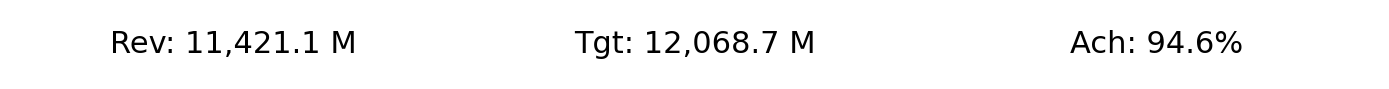

In [19]:
''' YTD Revenue '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
# ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Rev: {format(unit_mb(ytd_rev),',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(ytd_tgt),',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(ytd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

# ax4.text(0.5, 0.5, f"YoY: {format(ytd_yoy,',.1%')}", size=22, ha='center', va='center')
# ax4.spines[['top','left','right','bottom']].set_visible(False)
# ax4.set_axis_off()

fig.tight_layout()
plt.show()

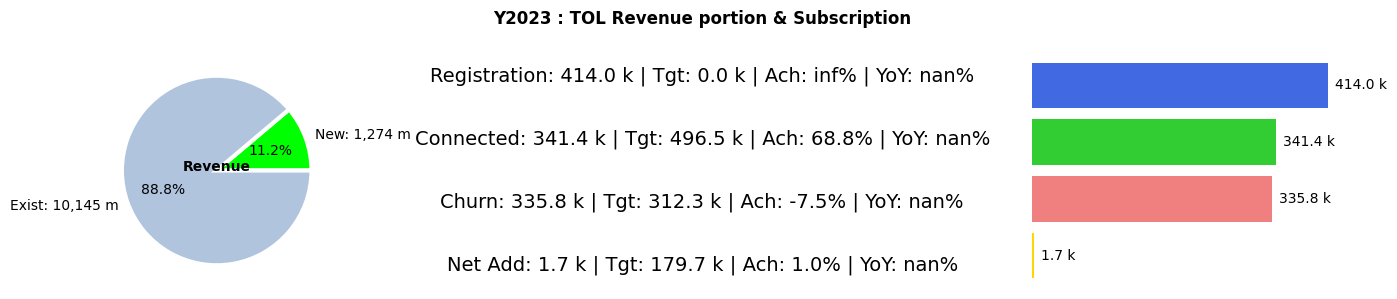

In [20]:
'''' Revenue Portion & Subscription '''

fig = plt.figure(figsize=(14, 3))
fig.suptitle(f'Y{curr_yr} : {v_product} Revenue portion & Subscription', weight='bold')
gs = GridSpec(4, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[2, 1])
ax5 = fig.add_subplot(gs[3, 1])
ax6 = fig.add_subplot(gs[:, 2])

''' ax1 '''
y = np.array([unit_mb(ytd_rev_new.sum()), unit_mb(ytd_rev_exist.sum())])
mylabels = [f"New: {format(y[0],',.0f')} m", f"Exist: {format(y[1],',.0f')} m"]
mycolors = ["lime", "lightsteelblue"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 3, "edgecolor": "white"})
ax1.text(0, 0, 'Revenue', ha='center', fontsize=10, weight='bold')

''' ax2 '''
ax2.text(0.5, 0.5, 
         f"Registration: {format(unit_k(ytd_reg_sub),',.1f')} k | Tgt: {format(unit_k(ytd_tgt_reg_sub),',.1f')} k | Ach: {format(ytd_achv_reg_sub,',.1%')} | YoY: {format(ytd_yoy_reg_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

''' ax3 '''
ax3.text(0.5, 0.5, 
         f"Connected: {format(unit_k(ytd_con_sub),',.1f')} k | Tgt: {format(unit_k(ytd_tgt_con_sub),',.1f')} k | Ach: {format(ytd_achv_con_sub,',.1%')} | YoY: {format(ytd_yoy_con_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

''' ax4 '''
ax4.text(0.5, 0.5, 
         f"Churn: {format(unit_k(ytd_chrn_sub),',.1f')} k | Tgt: {format(unit_k(ytd_tgt_chrn_sub),',.1f')} k | Ach: {format(ytd_achv_chrn_sub,',.1%')} | YoY: {format(ytd_yoy_chrn_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

''' ax5 '''
ax5.text(0.5, 0.5, 
         f"Net Add: {format(unit_k(ytd_net_add),',.1f')} k | Tgt: {format(unit_k(ytd_tgt_net_add),',.1f')} k | Ach: {format(ytd_achv_net_add,',.1%')} | YoY: {format(ytd_yoy_net_add,',.1%')}", 
         size=14, ha='center', va='center')
ax5.spines[['top','left','right','bottom']].set_visible(False)
ax5.set_axis_off()

''' ax6 '''
bars = ax6.barh(df_bar_h_ytd['METRIC_NAME'], width=unit_k(df_bar_h_ytd['VALUES']), color=df_bar_h_ytd['COLOR'])
# ax6.bar_label(bars, label_type='edge', padding=-45, fontweight='bold', fmt='%.1f k', color='white')
ax6.bar_label(bars, padding=5, fmt='%.1f k')
ax6.spines[['top','left','right','bottom']].set_visible(False)
ax6 = plt.gca()
ax6.get_xaxis().set_visible(False)
ax6.get_yaxis().set_visible(False)

fig.tight_layout()
plt.show()

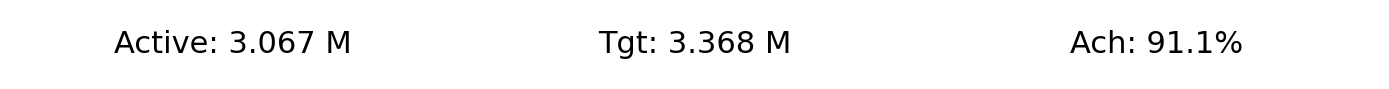

In [21]:
''' YTD Active Subs '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])

ax1.text(0.5, 0.5, f"Active: {format(unit_mb(ytd_actv_sub),',.3f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(ytd_tgt_actv_sub),',.3f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(ytd_achv_actv_sub,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

fig.tight_layout()
plt.show()

## ** Monthly **

### MTH : Aggregation

In [22]:
''' Create Dataframe '''

df_agg_s_mth = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH', 'MTH_DESC', 'AGG_TYPE']).agg({'ACT': 'sum', 'TGT': 'sum'}).reset_index()
df_agg_n_mth = df_agg_n.loc[df_agg_n.groupby('TM_KEY_MTH')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH', 'MTH_DESC', 'AGG_TYPE', 'ACT', 'TGT']]
df_mth = pd.concat([df_agg_s_mth, df_agg_n_mth])

''' Aggregation '''
df_mth['%ACHV'] = np.where(df_mth['METRIC_NAME'].str.contains("Churn"), -((df_mth['ACT']/df_mth['TGT'])-1), df_mth['ACT']/df_mth['TGT']) 
df_mth['GAP'] = df_mth['ACT'] - df_mth['TGT']
df_mth['LAST_ACT'] = df_mth.groupby('METRIC_CD')['ACT'].shift()
df_mth['DIFF'] = df_mth['ACT'] - df_mth['LAST_ACT']
df_mth['%MOM'] = (df_mth['ACT'] / df_mth['LAST_ACT']) - 1

df_mth.tail(3)

,METRIC_CD,METRIC_NAME,TM_KEY_MTH,MTH_DESC,AGG_TYPE,ACT,TGT,%ACHV,GAP,LAST_ACT,DIFF,%MOM
101202,TB3S000500,TOL Active Subs,202308,August,N,3057103.0,3288645.0,0.929593,-231542.0,3058697.0,-1594.0,-0.000521
101232,TB3S000500,TOL Active Subs,202309,September,N,3067529.0,3329790.0,0.921238,-262261.0,3057103.0,10426.0,0.003410
101261,TB3S000500,TOL Active Subs,202310,October,N,3067252.0,3368280.0,0.910629,-301028.0,3067529.0,-277.0,-0.000090


In [23]:
''' Pivot by KPIS '''

df_mth_agg = df_mth.pivot(index=['TM_KEY_MTH', 'MTH_DESC'], columns='METRIC_NAME', 
                          values=['ACT', 'TGT', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%MOM']).rename(columns=cols_dict).reset_index()
df_mth_agg.tail(3)

TM_KEY_MTH   MTH_DESC        ACT                        \
METRIC_NAME                         ACTV_SUB CHRN_SUB           M1   
5               202308     August  3057103.0  39283.0  25387737.50   
6               202309  September  3067529.0  43336.0  24623140.02   
7               202310    October  3067252.0  41288.0  23200016.87   

                                                                   ...  \
METRIC_NAME         EXIST  CON_SUB  REG_SUB NET_ADD           NEW  ...   
5            1.256526e+09  40626.0  49466.0  1343.0  1.974161e+08  ...   
6            1.251753e+09  39112.0  47586.0 -4224.0  2.164819e+08  ...   
7            1.173963e+09  37085.0  45017.0 -8129.0  2.134784e+08  ...   

                     DIFF      %MOM                                          \
METRIC_NAME         TOTAL  ACTV_SUB  CHRN_SUB        M1     EXIST   CON_SUB   
5            2.443075e+07 -0.000521  0.115392  0.016250 -0.000821  0.017864   
6            1.429364e+07  0.003410  0.103174 -0.030117 -0.003798 -0.037267   
7           -7.907323e+07 -0.000090 -0.047259 -0.057796 -0.062145 -0.051826   

                                                     
METRIC_NAME   REG_SUB   NET_ADD       NEW     TOTAL  
5            0.025521 -0.713890  0.148080  0.017090  
6           -0.038006 -4.145197  0.096577  0.009831  
7           -0.053986  0.924479 -0.013874 -0.053856  

[3 rows x 65 columns]

In [24]:
''' MTD Values '''

day_cnt_curr_mth = len(df_day_agg[df_day_agg['TM_KEY_MTH']==curr_mth]['TM_KEY_DAY'].unique())
day_cnt_last_mth = len(df_day_agg[df_day_agg['TM_KEY_MTH']==last_mth]['TM_KEY_DAY'].unique())

''' Last Period : Values '''
last_mth_rev = df_mth_agg[df_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['TOTAL'].sum()
last_mth_rev_new = df_mth_agg[df_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['NEW'].sum()
last_mth_rev_exist = df_mth_agg[df_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['EXIST'].sum()
last_mth_actv_sub = df_mth_agg[df_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['ACTV_SUB'].sum()
last_mth_con_sub = df_mth_agg[df_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['CON_SUB'].sum()
last_mth_reg_sub = df_mth_agg[df_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['REG_SUB'].sum()
last_mth_chrn_sub = df_mth_agg[df_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['CHRN_SUB'].sum()
last_mth_net_add = df_mth_agg[df_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['NET_ADD'].sum()

''' TOTAL : Values '''
mtd_rev = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['TOTAL'].sum()
mtd_tgt = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['TOTAL'].sum()
mtd_achv = mtd_rev / mtd_tgt
mtd_last_rev = (last_mth_rev / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom = (mtd_rev / mtd_last_rev) - 1
mtd_gap = mtd_rev - mtd_last_rev

''' NEW : Values '''
mtd_rev_new = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['NEW'].sum()
mtd_tgt_new = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['NEW'].sum()
mtd_achv_new = mtd_rev_new / mtd_tgt_new
mtd_last_rev_new = (last_mth_rev_new / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom_new = (mtd_rev_new / mtd_last_rev_new) - 1
mtd_gap_new = mtd_rev_new - mtd_last_rev_new

''' EXIST : Values '''
mtd_rev_exist = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['EXIST'].sum()
mtd_tgt_exist = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['EXIST'].sum()
mtd_achv_exist = mtd_rev_exist / mtd_tgt_exist
mtd_last_rev_exist = (last_mth_rev_exist / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom_exist = (mtd_rev_exist / mtd_last_rev_exist) - 1
mtd_gap_exist = mtd_rev_exist - mtd_last_rev_exist

''' ACTV_SUB : Values '''
mtd_actv_sub = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['ACTV_SUB'].sum()
mtd_tgt_actv_sub = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['ACTV_SUB'].sum()
mtd_achv_actv_sub = mtd_actv_sub / mtd_tgt_actv_sub
mtd_last_actv_sub = (last_mth_actv_sub / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom_actv_sub = (mtd_actv_sub / mtd_last_actv_sub) - 1
mtd_gap_actv_sub = mtd_actv_sub - mtd_last_actv_sub

''' CON_SUB : Values '''
mtd_con_sub = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['CON_SUB'].sum()
mtd_tgt_con_sub = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['CON_SUB'].sum()
mtd_achv_con_sub = mtd_con_sub / mtd_tgt_con_sub
mtd_last_con_sub = (last_mth_con_sub / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom_con_sub = (mtd_con_sub / mtd_last_con_sub) - 1
mtd_gap_con_sub = mtd_con_sub - mtd_last_con_sub

''' REG_SUB : Values '''
mtd_reg_sub = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['REG_SUB'].sum()
mtd_tgt_reg_sub = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['REG_SUB'].sum()
mtd_achv_reg_sub = mtd_reg_sub / mtd_tgt_reg_sub
mtd_last_reg_sub = (last_mth_reg_sub / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom_reg_sub = (mtd_reg_sub / mtd_last_reg_sub) - 1
mtd_gap_reg_sub = mtd_reg_sub - mtd_last_reg_sub

''' CHRN_SUB : Values '''
mtd_chrn_sub = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['CHRN_SUB'].sum()
mtd_tgt_chrn_sub = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['CHRN_SUB'].sum()
mtd_achv_chrn_sub = -((mtd_chrn_sub / mtd_tgt_chrn_sub) - 1)
mtd_last_chrn_sub = (last_mth_chrn_sub / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom_chrn_sub = (mtd_chrn_sub / mtd_last_chrn_sub) - 1
mtd_gap_chrn_sub = mtd_chrn_sub - mtd_last_chrn_sub

''' NET_ADD : Values '''
mtd_net_add = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['NET_ADD'].sum()
mtd_tgt_net_add = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['NET_ADD'].sum()
mtd_achv_net_add = mtd_net_add / mtd_tgt_net_add
mtd_last_net_add = (last_mth_net_add / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom_net_add = (mtd_net_add / mtd_last_net_add) - 1
mtd_gap_net_add = mtd_net_add - mtd_last_net_add

C:\Users\Narut4\AppData\Local\Temp\ipykernel_33120\2430772320.py:59: RuntimeWarning: divide by zero encountered in scalar divide
  mtd_achv_reg_sub = mtd_reg_sub / mtd_tgt_reg_sub


In [25]:
''' MTD BarH Dataframe'''

df_bar_h_mtd = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['ACT'][['CON_SUB', 'REG_SUB', 'CHRN_SUB', 'NET_ADD']].T.reset_index()
df_bar_h_mtd.columns = ['METRIC_NAME', 'VALUES']

color_conditions = [df_bar_h_mtd['METRIC_NAME']=='REG_SUB', 
                    df_bar_h_mtd['METRIC_NAME']=='CON_SUB', 
                    df_bar_h_mtd['METRIC_NAME']=='CHRN_SUB', 
                    df_bar_h_mtd['METRIC_NAME']=='NET_ADD',]
color_results = ['royalblue', 'limegreen', 'lightcoral', 'gold']
sort_results = [1, 2, 3, 4]

df_bar_h_mtd['COLOR'] = np.select(color_conditions, color_results)
df_bar_h_mtd['SORT_NO'] = np.select(color_conditions, sort_results)

df_bar_h_mtd = df_bar_h_mtd.sort_values(by='SORT_NO', ascending=False)
df_bar_h_mtd

,METRIC_NAME,VALUES,COLOR,SORT_NO
3,NET_ADD,-8129.0,gold,4
2,CHRN_SUB,41288.0,lightcoral,3
0,CON_SUB,37085.0,limegreen,2
1,REG_SUB,45017.0,royalblue,1


In [26]:
''' Month Chart Values '''

x_mth = df_mth_agg['MTH_DESC']
x_mth_axis = np.arange(len(x_mth))

''' TOTAL : Values '''
y_mth_act = df_mth_agg['ACT']['TOTAL']
y_mth_tgt = df_mth_agg['TGT']['TOTAL']
y_mth_achv = df_mth_agg['%ACHV']['TOTAL']
y_mth_gap = df_mth_agg['GAP']['TOTAL']
y_mth_diff = df_mth_agg['DIFF']['TOTAL']
y_mth_last_act = df_mth_agg['LAST_ACT']['TOTAL']
y_mth_mom = df_mth_agg['%MOM']['TOTAL']

''' NEW : Values '''
y_mth_act_new = df_mth_agg['ACT']['NEW']
y_mth_tgt_new = df_mth_agg['TGT']['NEW']
y_mth_achv_new = df_mth_agg['%ACHV']['NEW']
y_mth_gap_new = df_mth_agg['GAP']['NEW']
y_mth_diff_new = df_mth_agg['DIFF']['NEW']
y_mth_last_act_new = df_mth_agg['LAST_ACT']['NEW']
y_mth_mom_new = df_mth_agg['%MOM']['NEW']

''' EXIST : Values '''
y_mth_act_exist = df_mth_agg['ACT']['EXIST']
y_mth_tgt_exist = df_mth_agg['TGT']['EXIST']
y_mth_achv_exist = df_mth_agg['%ACHV']['EXIST']
y_mth_gap_exist = df_mth_agg['GAP']['EXIST']
y_mth_diff_exist = df_mth_agg['DIFF']['EXIST']
y_mth_last_act_exist = df_mth_agg['LAST_ACT']['EXIST']
y_mth_mom_exist = df_mth_agg['%MOM']['EXIST']

''' ACTV_SUB : Values '''
y_mth_act_actv_sub = df_mth_agg['ACT']['ACTV_SUB']
y_mth_tgt_actv_sub = df_mth_agg['TGT']['ACTV_SUB']
y_mth_achv_actv_sub = df_mth_agg['%ACHV']['ACTV_SUB']
y_mth_gap_actv_sub = df_mth_agg['GAP']['ACTV_SUB']
y_mth_diff_actv_sub = df_mth_agg['DIFF']['ACTV_SUB']
y_mth_last_act_actv_sub = df_mth_agg['LAST_ACT']['ACTV_SUB']
y_mth_mom_actv_sub = df_mth_agg['%MOM']['ACTV_SUB']

''' CON_SUB : Values '''
y_mth_act_con_sub = df_mth_agg['ACT']['CON_SUB']
y_mth_tgt_con_sub = df_mth_agg['TGT']['CON_SUB']
y_mth_achv_con_sub = df_mth_agg['%ACHV']['CON_SUB']
y_mth_gap_con_sub = df_mth_agg['GAP']['CON_SUB']
y_mth_diff_con_sub = df_mth_agg['DIFF']['CON_SUB']
y_mth_last_act_con_sub = df_mth_agg['LAST_ACT']['CON_SUB']
y_mth_mom_con_sub = df_mth_agg['%MOM']['CON_SUB']

''' REG_SUB : Values '''
y_mth_act_reg_sub = df_mth_agg['ACT']['REG_SUB']
y_mth_tgt_reg_sub = df_mth_agg['TGT']['REG_SUB']
y_mth_achv_reg_sub = df_mth_agg['%ACHV']['REG_SUB']
y_mth_gap_reg_sub = df_mth_agg['GAP']['REG_SUB']
y_mth_diff_reg_sub = df_mth_agg['DIFF']['REG_SUB']
y_mth_last_act_reg_sub = df_mth_agg['LAST_ACT']['REG_SUB']
y_mth_mom_reg_sub = df_mth_agg['%MOM']['REG_SUB']

''' CHRN_SUB : Values '''
y_mth_act_chrn_sub = df_mth_agg['ACT']['CHRN_SUB']
y_mth_tgt_chrn_sub = df_mth_agg['TGT']['CHRN_SUB']
y_mth_achv_chrn_sub = df_mth_agg['%ACHV']['CHRN_SUB']
y_mth_gap_chrn_sub = df_mth_agg['GAP']['CHRN_SUB']
y_mth_diff_chrn_sub = df_mth_agg['DIFF']['CHRN_SUB']
y_mth_last_act_chrn_sub = df_mth_agg['LAST_ACT']['CHRN_SUB']
y_mth_mom_chrn_sub = df_mth_agg['%MOM']['CHRN_SUB']

''' NET_ADD : Values '''
y_mth_act_net_add = df_mth_agg['ACT']['NET_ADD']
y_mth_tgt_net_add = df_mth_agg['TGT']['NET_ADD']
y_mth_achv_net_add = df_mth_agg['%ACHV']['NET_ADD']
y_mth_gap_net_add = df_mth_agg['GAP']['NET_ADD']
y_mth_diff_net_add = df_mth_agg['DIFF']['NET_ADD']
y_mth_last_act_net_add = df_mth_agg['LAST_ACT']['NET_ADD']
y_mth_mom_net_add = df_mth_agg['%MOM']['NET_ADD']

### MTH : Visualizations

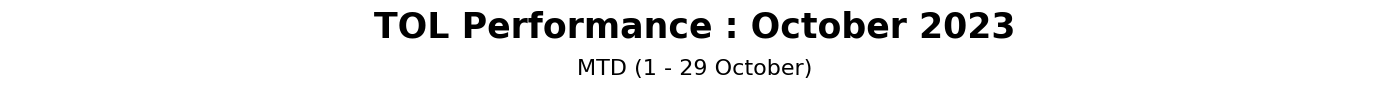

In [27]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"{v_product} Performance : {curr_mth_desc} {curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"MTD (1 - {curr_day_label} {curr_mth_desc})", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

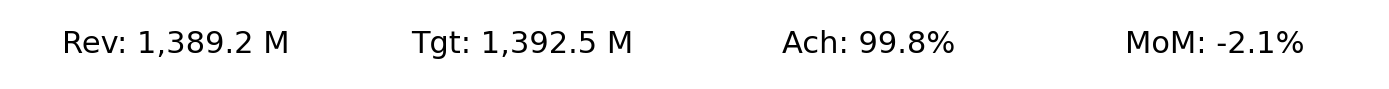

In [28]:
''' MTD Revenue '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Rev: {format(unit_mb(mtd_rev),',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(mtd_tgt),',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(mtd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"MoM: {format(mtd_mom,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

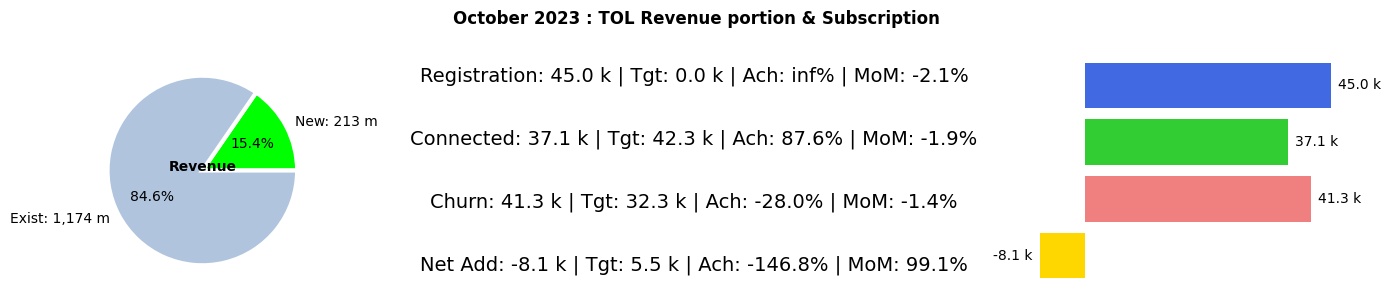

In [29]:
'''' Revenue Portion & Subscription '''

fig = plt.figure(figsize=(14, 3))
fig.suptitle(f'{curr_mth_desc} {curr_yr} : {v_product} Revenue portion & Subscription', weight='bold')
gs = GridSpec(4, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[2, 1])
ax5 = fig.add_subplot(gs[3, 1])
ax6 = fig.add_subplot(gs[:, 2])

''' ax1 '''
y = np.array([unit_mb(mtd_rev_new.sum()), unit_mb(mtd_rev_exist.sum())])
mylabels = [f"New: {format(y[0],',.0f')} m", f"Exist: {format(y[1],',.0f')} m"]
mycolors = ["lime", "lightsteelblue"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 3, "edgecolor": "white"})
ax1.text(0, 0, 'Revenue', ha='center', fontsize=10, weight='bold')

''' ax2 '''
ax2.text(0.5, 0.5, 
         f"Registration: {format(unit_k(mtd_reg_sub),',.1f')} k | Tgt: {format(unit_k(mtd_tgt_reg_sub),',.1f')} k | Ach: {format(mtd_achv_reg_sub,',.1%')} | MoM: {format(mtd_mom_reg_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

''' ax3 '''
ax3.text(0.5, 0.5, 
         f"Connected: {format(unit_k(mtd_con_sub),',.1f')} k | Tgt: {format(unit_k(mtd_tgt_con_sub),',.1f')} k | Ach: {format(mtd_achv_con_sub,',.1%')} | MoM: {format(mtd_mom_con_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

''' ax4 '''
ax4.text(0.5, 0.5, 
         f"Churn: {format(unit_k(mtd_chrn_sub),',.1f')} k | Tgt: {format(unit_k(mtd_tgt_chrn_sub),',.1f')} k | Ach: {format(mtd_achv_chrn_sub,',.1%')} | MoM: {format(mtd_mom_chrn_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

''' ax5 '''
ax5.text(0.5, 0.5, 
         f"Net Add: {format(unit_k(mtd_net_add),',.1f')} k | Tgt: {format(unit_k(mtd_tgt_net_add),',.1f')} k | Ach: {format(mtd_achv_net_add,',.1%')} | MoM: {format(mtd_mom_net_add,',.1%')}", 
         size=14, ha='center', va='center')
ax5.spines[['top','left','right','bottom']].set_visible(False)
ax5.set_axis_off()

''' ax6 '''
bars = ax6.barh(df_bar_h_mtd['METRIC_NAME'], width=unit_k(df_bar_h_mtd['VALUES']), color=df_bar_h_mtd['COLOR'])
ax6.bar_label(bars, padding=5, fmt='%.1f k')
ax6.spines[['top','left','right','bottom']].set_visible(False)
ax6 = plt.gca()
ax6.get_xaxis().set_visible(False)
ax6.get_yaxis().set_visible(False)

fig.tight_layout()
plt.show()

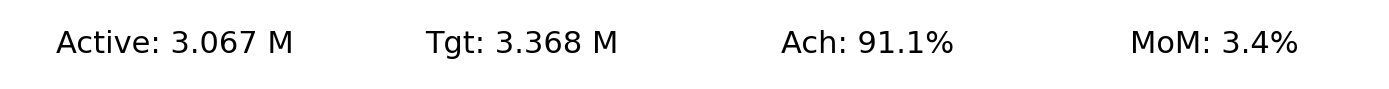

In [30]:
''' MTD Active Subs '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Active: {format(unit_mb(mtd_actv_sub),',.3f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(mtd_tgt_actv_sub),',.3f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(mtd_achv_actv_sub,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"MoM: {format(mtd_mom_actv_sub,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

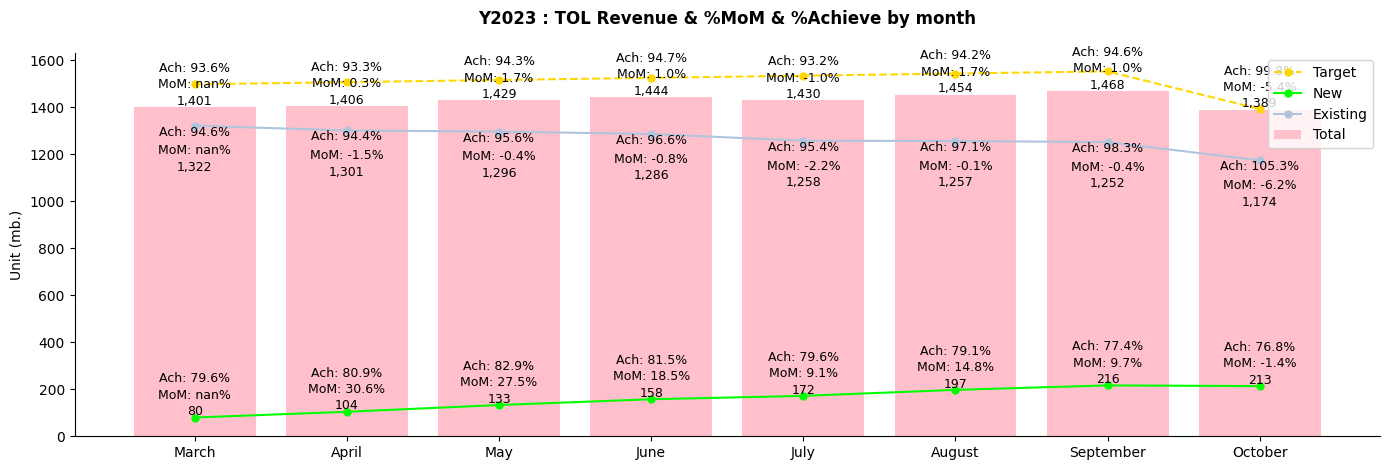

In [31]:
''' Revenue & MoM & Achieve by month '''

plt.figure().set_figwidth(14)
plt.title(f"Y{curr_yr} : {v_product} Revenue & %MoM & %Achieve by month\n", weight='bold')

plt.bar(x_mth_axis, unit_mb(y_mth_act), label='Total', color='pink')

plt.plot(x_mth_axis, unit_mb(y_mth_tgt), marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
plt.plot(x_mth_axis, unit_mb(y_mth_act_new), marker='.', markeredgewidth=3, label='New', color='lime')
plt.plot(x_mth_axis, unit_mb(y_mth_act_exist), marker='.', markeredgewidth=3, label='Existing', color='lightsteelblue')

for i in x_mth_axis:
    plt.annotate(f"Ach: {format(y_mth_achv[i],',.1%')}", xy=(x_mth_axis[i], unit_mb(y_mth_act[i])+150), ha='center', fontsize=9)
    plt.annotate(f"MoM: {format(y_mth_mom[i],',.1%')}", xy=(x_mth_axis[i], unit_mb(y_mth_act[i])+80), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_mth_act[i]),',.0f'), xy=(x_mth_axis[i], unit_mb(y_mth_act[i])+10), ha='center', fontsize=9)

    plt.annotate(f"Ach: {format(y_mth_achv_new[i],',.1%')}", xy=(x_mth_axis[i], unit_mb(y_mth_act_new[i])+150), ha='center', fontsize=9)
    plt.annotate(f"MoM: {format(y_mth_mom_new[i],',.1%')}", xy=(x_mth_axis[i], unit_mb(y_mth_act_new[i])+80), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_mth_act_new[i]),',.0f'), xy=(x_mth_axis[i], unit_mb(y_mth_act_new[i])+10), ha='center', fontsize=9)
    
    plt.annotate(f"Ach: {format(y_mth_achv_exist[i],',.1%')}", xy=(x_mth_axis[i], unit_mb(y_mth_act_exist[i]-10)), ha='center', va='top', fontsize=9)
    plt.annotate(f"MoM: {format(y_mth_mom_exist[i],',.1%')}", xy=(x_mth_axis[i], unit_mb(y_mth_act_exist[i])-80), ha='center', va='top', fontsize=9)
    plt.annotate(format(unit_mb(y_mth_act_exist[i]),',.0f'), xy=(x_mth_axis[i], unit_mb(y_mth_act_exist[i])-150), ha='center', va='top', fontsize=9)

plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
plt.legend()
plt.tight_layout()
plt.show()

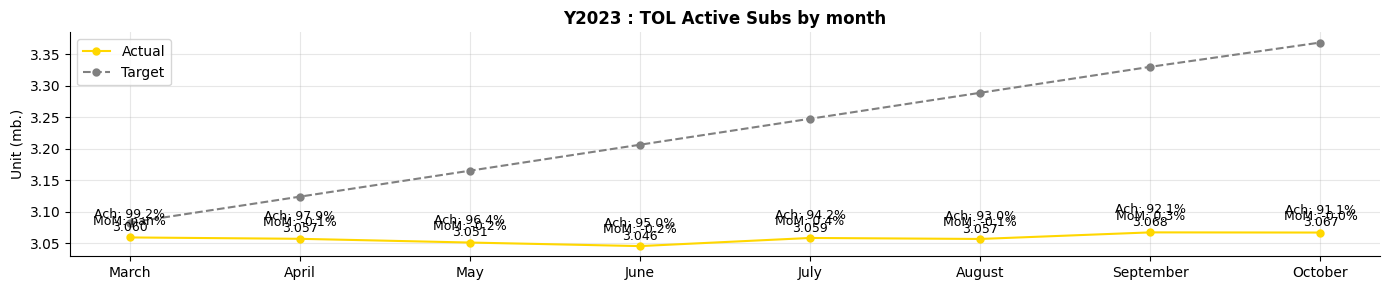

In [32]:
''' Active Subs by month '''

plt.figure(figsize=(14, 3))
plt.title(f"Y{curr_yr} : {v_product} Active Subs by month", weight='bold')

plt.plot(x_mth_axis, unit_mb(y_mth_act_actv_sub), marker='.', markeredgewidth=3, label='Actual', color='gold')
plt.plot(x_mth_axis, unit_mb(y_mth_tgt_actv_sub), marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='grey')
for i in x_mth_axis:
    plt.annotate(f"Ach: {format(y_mth_achv_actv_sub[i],',.1%')}", xy=(x_mth_axis[i], unit_mb(y_mth_act_actv_sub[i])+0.03), ha='center', fontsize=9)
    plt.annotate(f"MoM: {format(y_mth_mom_actv_sub[i],',.1%')}", xy=(x_mth_axis[i], unit_mb(y_mth_act_actv_sub[i])+0.02), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_mth_act_actv_sub[i]),',.3f'), xy=(x_mth_axis[i], unit_mb(y_mth_act_actv_sub[i])+0.01), ha='center', fontsize=9)

plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

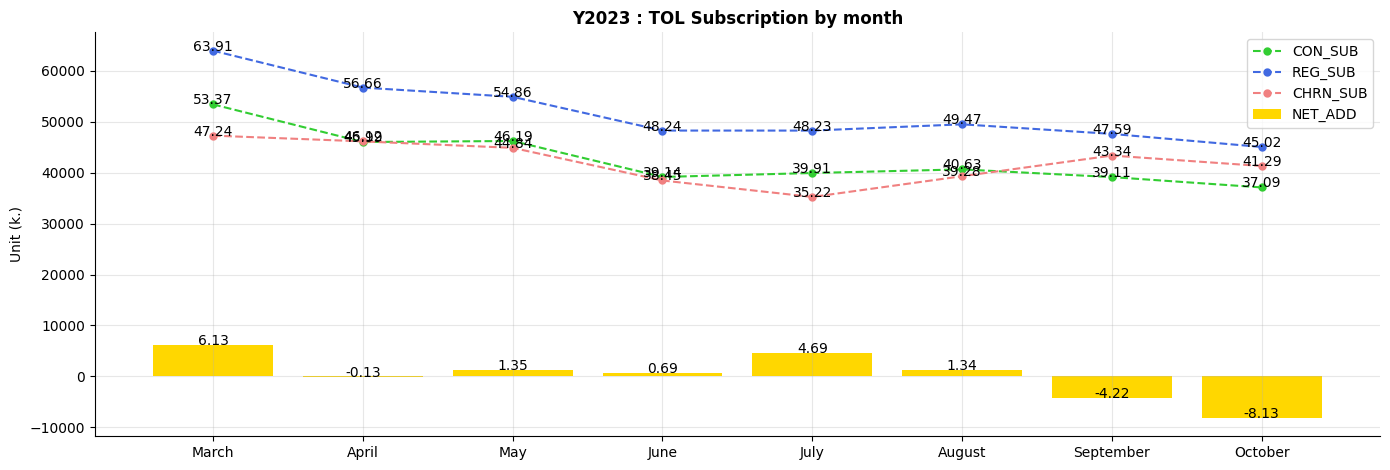

In [33]:
''' Subscription by month '''

plt.figure().set_figwidth(14)
plt.title(f"Y{curr_yr} : {v_product} Subscription by month", weight='bold')

plt.plot(x_mth_axis, y_mth_act_con_sub, marker='.', linestyle='dashed', markeredgewidth=3, label='CON_SUB', color='limegreen')
plt.plot(x_mth_axis, y_mth_act_reg_sub, marker='.', linestyle='dashed', markeredgewidth=3, label='REG_SUB', color='royalblue')
plt.plot(x_mth_axis, y_mth_act_chrn_sub, marker='.', linestyle='dashed', markeredgewidth=3, label='CHRN_SUB', color='lightcoral')
plt.bar(x_mth_axis, y_mth_act_net_add, label='NET_ADD', color='gold')
for i in x_mth_axis:
    plt.annotate(format(unit_k(y_mth_act_con_sub[i]),',.2f'), xy=(x_mth_axis[i], y_mth_act_con_sub[i]), ha='center')
    plt.annotate(format(unit_k(y_mth_act_reg_sub[i]),',.2f'), xy=(x_mth_axis[i], y_mth_act_reg_sub[i]), ha='center')
    plt.annotate(format(unit_k(y_mth_act_chrn_sub[i]),',.2f'), xy=(x_mth_axis[i], y_mth_act_chrn_sub[i]), ha='center')
    plt.annotate(format(unit_k(y_mth_act_net_add[i]),',.2f'), xy=(x_mth_axis[i], y_mth_act_net_add[i]), ha='center')

plt.ylabel('Unit (k.)')
plt.xticks(x_mth_axis, x_mth)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## ** Weekly **

### WK : Aggregation

In [34]:
''' Create Dataframe '''

df_agg_s_wk = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'WK_LABEL', 'AGG_TYPE']).agg({'ACT': 'sum', 'TGT': 'sum'}).reset_index()
df_agg_n_wk = df_agg_n.loc[df_agg_n.groupby('TM_KEY_WK')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'WK_LABEL', 'AGG_TYPE', 'ACT', 'TGT']]
df_wk = pd.concat([df_agg_s_wk, df_agg_n_wk])

''' Aggregation '''
df_wk['%ACHV'] = np.where(df_wk['METRIC_NAME'].str.contains("Churn"), -((df_wk['ACT']/df_wk['TGT'])-1), df_wk['ACT']/df_wk['TGT']) 
df_wk['GAP'] = df_wk['ACT'] - df_wk['TGT']
df_wk['LAST_ACT'] = df_wk.groupby('METRIC_CD')['ACT'].shift()
df_wk['DIFF'] = df_wk['ACT'] - df_wk['LAST_ACT']
df_wk['%WOW'] = (df_wk['ACT'] / df_wk['LAST_ACT']) - 1

df_wk.tail(3)

,METRIC_CD,METRIC_NAME,TM_KEY_WK,WK_LABEL,AGG_TYPE,ACT,TGT,%ACHV,GAP,LAST_ACT,DIFF,%WOW
101247,TB3S000500,TOL Active Subs,2023041,41,N,3059167.0,3349699.0,0.913266,-290532.0,3069797.0,-10630.0,-0.003463
101254,TB3S000500,TOL Active Subs,2023042,42,N,3059167.0,3358990.0,0.910740,-299823.0,3059167.0,0.0,0.000000
101261,TB3S000500,TOL Active Subs,2023043,43,N,3067252.0,3368280.0,0.910629,-301028.0,3059167.0,8085.0,0.002643


In [35]:
''' Pivot by KPIS '''

df_wk_agg = df_wk.pivot(index=['TM_KEY_WK', 'WK_LABEL'], columns='METRIC_NAME', 
                        values=['ACT', 'TGT', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%WOW']).rename(columns=cols_dict).reset_index()
df_wk_agg.tail(3)

TM_KEY_WK WK_LABEL        ACT                                     \
METRIC_NAME                      ACTV_SUB CHRN_SUB          M1         EXIST   
32            2023041       41  3059167.0  18277.0  5746140.36  3.410094e+08   
33            2023042       42  3059167.0   8862.0  5914743.75  4.356954e+08   
34            2023043       43  3067252.0   1986.0  4662261.05  1.402641e+08   

                                                    ...          DIFF  \
METRIC_NAME CON_SUB  REG_SUB NET_ADD           NEW  ...         TOTAL   
32           9181.0  11540.0 -9096.0  5.832067e+07  ...  8.108682e+07   
33           9409.0  10974.0   547.0  6.989566e+07  ...  1.066987e+08   
34           7801.0   9448.0  1889.0  2.337198e+07  ... -3.430341e+08   

                 %WOW                                                    \
METRIC_NAME  ACTV_SUB  CHRN_SUB        M1     EXIST   CON_SUB   REG_SUB   
32          -0.003463  0.644059 -0.066082  0.326913 -0.026508 -0.013591   
33           0.000000 -0.515128  0.029342  0.277664  0.024834 -0.049047   
34           0.002643 -0.775897 -0.211756 -0.678069 -0.170900 -0.139056   

                                           
METRIC_NAME   NET_ADD       NEW     TOTAL  
32           4.395018 -0.057674  0.254283  
33          -1.060136  0.198471  0.266766  
34           2.453382 -0.665616 -0.677036  

[3 rows x 65 columns]

In [36]:
''' WTD Values '''

day_cnt_curr_wk = len(df_day_agg[df_day_agg['TM_KEY_WK']==curr_wk]['TM_KEY_DAY'].unique())
day_cnt_last_wk = len(df_day_agg[df_day_agg['TM_KEY_WK']==last_wk]['TM_KEY_DAY'].unique())

''' Last Period : Values '''
last_wk_rev = df_wk_agg[df_wk_agg['TM_KEY_WK']==last_wk]['ACT']['TOTAL'].sum()
last_wk_rev_new = df_wk_agg[df_wk_agg['TM_KEY_WK']==last_wk]['ACT']['NEW'].sum()
last_wk_rev_exist = df_wk_agg[df_wk_agg['TM_KEY_WK']==last_wk]['ACT']['EXIST'].sum()
last_wk_actv_sub = df_wk_agg[df_wk_agg['TM_KEY_WK']==last_wk]['ACT']['ACTV_SUB'].sum()
last_wk_con_sub = df_wk_agg[df_wk_agg['TM_KEY_WK']==last_wk]['ACT']['CON_SUB'].sum()
last_wk_reg_sub = df_wk_agg[df_wk_agg['TM_KEY_WK']==last_wk]['ACT']['REG_SUB'].sum()
last_wk_chrn_sub = df_wk_agg[df_wk_agg['TM_KEY_WK']==last_wk]['ACT']['CHRN_SUB'].sum()
last_wk_net_add = df_wk_agg[df_wk_agg['TM_KEY_WK']==last_wk]['ACT']['NET_ADD'].sum()

''' TOTAL : Values '''
wtd_rev = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['TOTAL'].sum()
wtd_tgt = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['TOTAL'].sum()
wtd_achv = wtd_rev / wtd_tgt
wtd_last_rev = (last_wk_rev / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow = (wtd_rev / wtd_last_rev) - 1
wtd_gap = wtd_rev - wtd_last_rev

''' NEW : Values '''
wtd_rev_new = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['NEW'].sum()
wtd_tgt_new = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['NEW'].sum()
wtd_achv_new = wtd_rev_new / wtd_tgt_new
wtd_last_rev_new = (last_wk_rev_new / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow_new = (wtd_rev_new / wtd_last_rev_new) - 1
wtd_gap_new = wtd_rev_new - wtd_last_rev_new

''' EXIST : Values '''
wtd_rev_exist = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['EXIST'].sum()
wtd_tgt_exist = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['EXIST'].sum()
wtd_achv_exist = wtd_rev_exist / wtd_tgt_exist
wtd_last_rev_exist = (last_wk_rev_exist / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow_exist = (wtd_rev_exist / wtd_last_rev_exist) - 1
wtd_gap_exist = wtd_rev_exist - wtd_last_rev_exist

''' ACTV_SUB : Values '''
wtd_actv_sub = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['ACTV_SUB'].sum()
wtd_tgt_actv_sub = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['ACTV_SUB'].sum()
wtd_achv_actv_sub = wtd_actv_sub / wtd_tgt_actv_sub
wtd_last_actv_sub = (last_wk_actv_sub / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow_actv_sub = (wtd_actv_sub / wtd_last_actv_sub) - 1
wtd_gap_actv_sub = wtd_actv_sub - wtd_last_actv_sub

''' CON_SUB : Values '''
wtd_con_sub = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['CON_SUB'].sum()
wtd_tgt_con_sub = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['CON_SUB'].sum()
wtd_achv_con_sub = wtd_con_sub / wtd_tgt_con_sub
wtd_last_con_sub = (last_wk_con_sub / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow_con_sub = (wtd_con_sub / wtd_last_con_sub) - 1
wtd_gap_con_sub = wtd_con_sub - wtd_last_con_sub

''' REG_SUB : Values '''
wtd_reg_sub = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['REG_SUB'].sum()
wtd_tgt_reg_sub = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['REG_SUB'].sum()
wtd_achv_reg_sub = wtd_reg_sub / wtd_tgt_reg_sub
wtd_last_reg_sub = (last_wk_reg_sub / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow_reg_sub = (wtd_reg_sub / wtd_last_reg_sub) - 1
wtd_gap_reg_sub = wtd_reg_sub - wtd_last_reg_sub

''' CHRN_SUB : Values '''
wtd_chrn_sub = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['CHRN_SUB'].sum()
wtd_tgt_chrn_sub = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['CHRN_SUB'].sum()
wtd_achv_chrn_sub = -((wtd_chrn_sub / wtd_tgt_chrn_sub) - 1)
wtd_last_chrn_sub = (last_wk_chrn_sub / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow_chrn_sub = (wtd_chrn_sub / wtd_last_chrn_sub) - 1
wtd_gap_chrn_sub = wtd_chrn_sub - wtd_last_chrn_sub

''' NET_ADD : Values '''
wtd_net_add = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['NET_ADD'].sum()
wtd_tgt_net_add = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['NET_ADD'].sum()
wtd_achv_net_add = wtd_net_add / wtd_tgt_net_add
wtd_last_net_add = (last_wk_net_add / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow_net_add = (wtd_net_add / wtd_last_net_add) - 1
wtd_gap_net_add = wtd_net_add - wtd_last_net_add

C:\Users\Narut4\AppData\Local\Temp\ipykernel_33120\964337627.py:59: RuntimeWarning: divide by zero encountered in scalar divide
  wtd_achv_reg_sub = wtd_reg_sub / wtd_tgt_reg_sub


In [37]:
''' WTD BarH Dataframe'''

df_bar_h_wtd = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['ACT'][['CON_SUB', 'REG_SUB', 'CHRN_SUB', 'NET_ADD']].T.reset_index()
df_bar_h_wtd.columns = ['METRIC_NAME', 'VALUES']

color_conditions = [df_bar_h_wtd['METRIC_NAME']=='REG_SUB', 
                    df_bar_h_wtd['METRIC_NAME']=='CON_SUB', 
                    df_bar_h_wtd['METRIC_NAME']=='CHRN_SUB', 
                    df_bar_h_wtd['METRIC_NAME']=='NET_ADD',]
color_results = ['royalblue', 'limegreen', 'lightcoral', 'gold']
sort_results = [1, 2, 3, 4]

df_bar_h_wtd['COLOR'] = np.select(color_conditions, color_results)
df_bar_h_wtd['SORT_NO'] = np.select(color_conditions, sort_results)

df_bar_h_wtd = df_bar_h_wtd.sort_values(by='SORT_NO', ascending=False)
df_bar_h_wtd

,METRIC_NAME,VALUES,COLOR,SORT_NO
3,NET_ADD,1889.0,gold,4
2,CHRN_SUB,1986.0,lightcoral,3
0,CON_SUB,7801.0,limegreen,2
1,REG_SUB,9448.0,royalblue,1


In [38]:
''' Week Chart Values '''

x_wk = df_wk_agg['WK_LABEL']
x_wk_axis = np.arange(len(x_wk))

''' TOTAL : Values '''
y_wk_act = df_wk_agg['ACT']['TOTAL']
y_wk_tgt = df_wk_agg['TGT']['TOTAL']
y_wk_achv = df_wk_agg['%ACHV']['TOTAL']
y_wk_gap = df_wk_agg['GAP']['TOTAL']
y_wk_diff = df_wk_agg['DIFF']['TOTAL']
y_wk_last_act = df_wk_agg['LAST_ACT']['TOTAL']
y_wk_wow = df_wk_agg['%WOW']['TOTAL']

''' NEW : Values '''
y_wk_act_new = df_wk_agg['ACT']['NEW']
y_wk_tgt_new = df_wk_agg['TGT']['NEW']
y_wk_achv_new = df_wk_agg['%ACHV']['NEW']
y_wk_gap_new = df_wk_agg['GAP']['NEW']
y_wk_diff_new = df_wk_agg['DIFF']['NEW']
y_wk_last_act_new = df_wk_agg['LAST_ACT']['NEW']
y_wk_wow_new = df_wk_agg['%WOW']['NEW']

''' EXIST : Values '''
y_wk_act_exist = df_wk_agg['ACT']['EXIST']
y_wk_tgt_exist = df_wk_agg['TGT']['EXIST']
y_wk_achv_exist = df_wk_agg['%ACHV']['EXIST']
y_wk_gap_exist = df_wk_agg['GAP']['EXIST']
y_wk_diff_exist = df_wk_agg['DIFF']['EXIST']
y_wk_last_act_exist = df_wk_agg['LAST_ACT']['EXIST']
y_wk_wow_exist = df_wk_agg['%WOW']['EXIST']

''' ACTV_SUB : Values '''
y_wk_act_actv_sub = df_wk_agg['ACT']['ACTV_SUB']
y_wk_tgt_actv_sub = df_wk_agg['TGT']['ACTV_SUB']
y_wk_achv_actv_sub = df_wk_agg['%ACHV']['ACTV_SUB']
y_wk_gap_actv_sub = df_wk_agg['GAP']['ACTV_SUB']
y_wk_diff_actv_sub = df_wk_agg['DIFF']['ACTV_SUB']
y_wk_last_act_actv_sub = df_wk_agg['LAST_ACT']['ACTV_SUB']
y_wk_wow_actv_sub = df_wk_agg['%WOW']['ACTV_SUB']

''' CON_SUB : Values '''
y_wk_act_con_sub = df_wk_agg['ACT']['CON_SUB']
y_wk_tgt_con_sub = df_wk_agg['TGT']['CON_SUB']
y_wk_achv_con_sub = df_wk_agg['%ACHV']['CON_SUB']
y_wk_gap_con_sub = df_wk_agg['GAP']['CON_SUB']
y_wk_diff_con_sub = df_wk_agg['DIFF']['CON_SUB']
y_wk_last_act_con_sub = df_wk_agg['LAST_ACT']['CON_SUB']
y_wk_wow_con_sub = df_wk_agg['%WOW']['CON_SUB']

''' REG_SUB : Values '''
y_wk_act_reg_sub = df_wk_agg['ACT']['REG_SUB']
y_wk_tgt_reg_sub = df_wk_agg['TGT']['REG_SUB']
y_wk_achv_reg_sub = df_wk_agg['%ACHV']['REG_SUB']
y_wk_gap_reg_sub = df_wk_agg['GAP']['REG_SUB']
y_wk_diff_reg_sub = df_wk_agg['DIFF']['REG_SUB']
y_wk_last_act_reg_sub = df_wk_agg['LAST_ACT']['REG_SUB']
y_wk_wow_reg_sub = df_wk_agg['%WOW']['REG_SUB']

''' CHRN_SUB : Values '''
y_wk_act_chrn_sub = df_wk_agg['ACT']['CHRN_SUB']
y_wk_tgt_chrn_sub = df_wk_agg['TGT']['CHRN_SUB']
y_wk_achv_chrn_sub = df_wk_agg['%ACHV']['CHRN_SUB']
y_wk_gap_chrn_sub = df_wk_agg['GAP']['CHRN_SUB']
y_wk_diff_chrn_sub = df_wk_agg['DIFF']['CHRN_SUB']
y_wk_last_act_chrn_sub = df_wk_agg['LAST_ACT']['CHRN_SUB']
y_wk_wow_chrn_sub = df_wk_agg['%WOW']['CHRN_SUB']

''' NET_ADD : Values '''
y_wk_act_net_add = df_wk_agg['ACT']['NET_ADD']
y_wk_tgt_net_add = df_wk_agg['TGT']['NET_ADD']
y_wk_achv_net_add = df_wk_agg['%ACHV']['NET_ADD']
y_wk_gap_net_add = df_wk_agg['GAP']['NET_ADD']
y_wk_diff_net_add = df_wk_agg['DIFF']['NET_ADD']
y_wk_last_act_net_add = df_wk_agg['LAST_ACT']['NET_ADD']
y_wk_wow_net_add = df_wk_agg['%WOW']['NET_ADD']

### WK : Visualizations

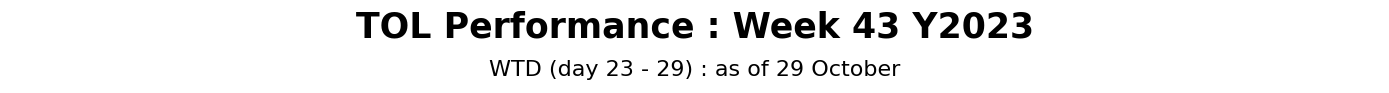

In [39]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"{v_product} Performance : Week {curr_wk_label} Y{curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"WTD (day {wk_day_start} - {wk_day_end}) : as of {curr_day_label} {curr_mth_desc}", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

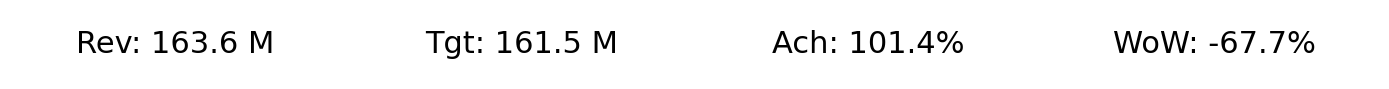

In [40]:
''' WTD Revenue '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Rev: {format(unit_mb(wtd_rev),',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(wtd_tgt),',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(wtd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"WoW: {format(wtd_wow,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

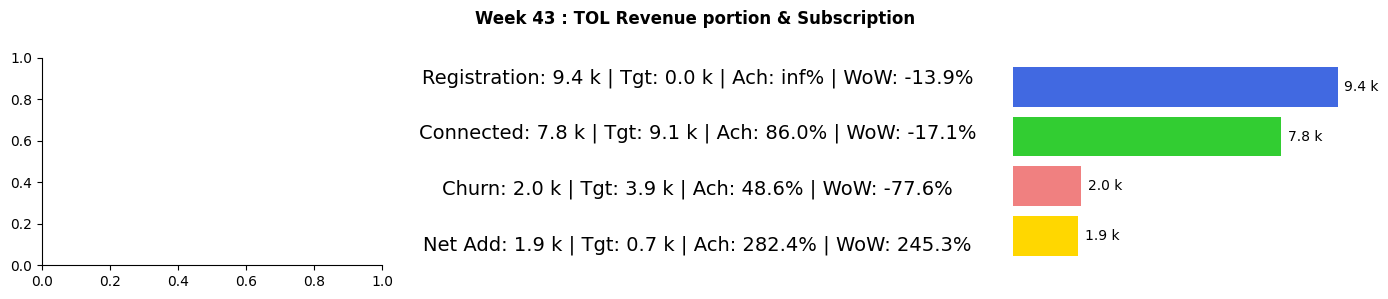

In [41]:
'''' Revenue Portion & Subscription '''

fig = plt.figure(figsize=(14, 3))
fig.suptitle(f'Week {curr_wk_label} : {v_product} Revenue portion & Subscription', weight='bold')
gs = GridSpec(4, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[2, 1])
ax5 = fig.add_subplot(gs[3, 1])
ax6 = fig.add_subplot(gs[:, 2])

# ''' ax1 '''
# y = np.array([unit_mb(wtd_rev_new.sum()), unit_mb(wtd_rev_exist.sum())])
# mylabels = [f"New: {format(y[0],',.0f')} m", f"Exist: {format(y[1],',.0f')} m"]
# mycolors = ["lime", "lightsteelblue"]
# ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 3, "edgecolor": "white"})
# ax1.text(0, 0, 'Revenue', ha='center', fontsize=10, weight='bold')

''' ax2 '''
ax2.text(0.5, 0.5, 
         f"Registration: {format(unit_k(wtd_reg_sub),',.1f')} k | Tgt: {format(unit_k(wtd_tgt_reg_sub),',.1f')} k | Ach: {format(wtd_achv_reg_sub,',.1%')} | WoW: {format(wtd_wow_reg_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

''' ax3 '''
ax3.text(0.5, 0.5, 
         f"Connected: {format(unit_k(wtd_con_sub),',.1f')} k | Tgt: {format(unit_k(wtd_tgt_con_sub),',.1f')} k | Ach: {format(wtd_achv_con_sub,',.1%')} | WoW: {format(wtd_wow_con_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

''' ax4 '''
ax4.text(0.5, 0.5, 
         f"Churn: {format(unit_k(wtd_chrn_sub),',.1f')} k | Tgt: {format(unit_k(wtd_tgt_chrn_sub),',.1f')} k | Ach: {format(wtd_achv_chrn_sub,',.1%')} | WoW: {format(wtd_wow_chrn_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

''' ax5 '''
ax5.text(0.5, 0.5, 
         f"Net Add: {format(unit_k(wtd_net_add),',.1f')} k | Tgt: {format(unit_k(wtd_tgt_net_add),',.1f')} k | Ach: {format(wtd_achv_net_add,',.1%')} | WoW: {format(wtd_wow_net_add,',.1%')}", 
         size=14, ha='center', va='center')
ax5.spines[['top','left','right','bottom']].set_visible(False)
ax5.set_axis_off()

''' ax6 '''
bars = ax6.barh(df_bar_h_wtd['METRIC_NAME'], width=unit_k(df_bar_h_wtd['VALUES']), color=df_bar_h_wtd['COLOR'])
ax6.bar_label(bars, padding=5, fmt='%.1f k')
ax6.spines[['top','left','right','bottom']].set_visible(False)
ax6 = plt.gca()
ax6.get_xaxis().set_visible(False)
ax6.get_yaxis().set_visible(False)

fig.tight_layout()
plt.show()

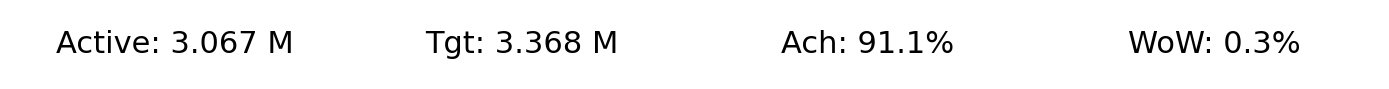

In [42]:
''' WTD Active Subs '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Active: {format(unit_mb(wtd_actv_sub),',.3f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(wtd_tgt_actv_sub),',.3f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(wtd_achv_actv_sub,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"WoW: {format(wtd_wow_actv_sub,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

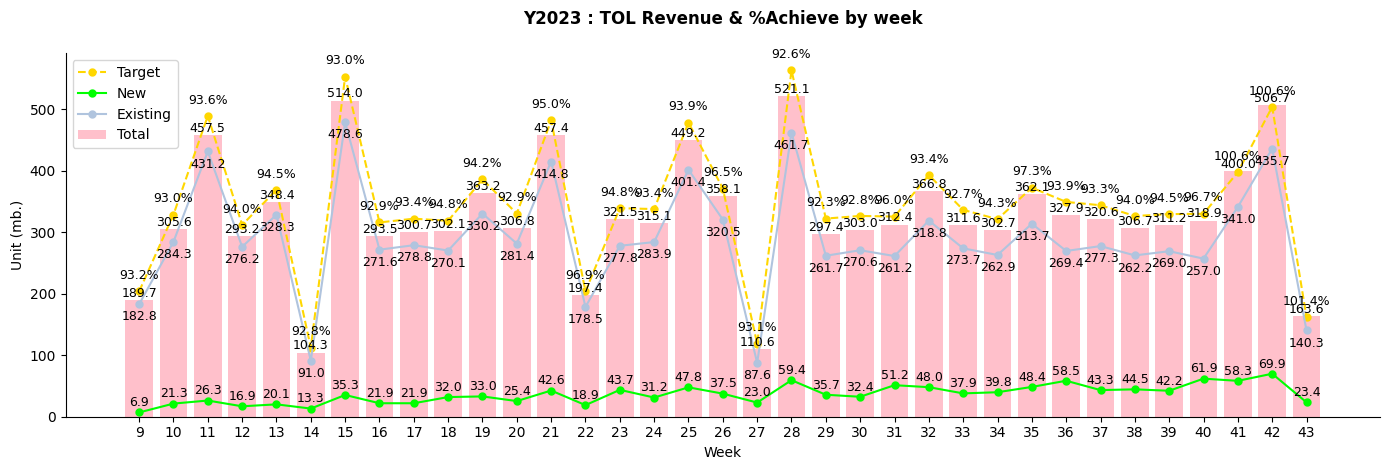

In [43]:
''' Revenue & Achieve by week '''

plt.figure().set_figwidth(14)
plt.title(f"Y{curr_yr} : {v_product} Revenue & %Achieve by week\n", weight='bold')

plt.bar(x_wk_axis, unit_mb(y_wk_act), label='Total', color='pink')

plt.plot(x_wk_axis, unit_mb(y_wk_tgt), marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
plt.plot(x_wk_axis, unit_mb(y_wk_act_new), marker='.', markeredgewidth=3, label='New', color='lime')
plt.plot(x_wk_axis, unit_mb(y_wk_act_exist), marker='.', markeredgewidth=3, label='Existing', color='lightsteelblue')

for i in x_wk_axis:
    plt.annotate(format(y_wk_achv[i],',.1%'), xy=(x_wk_axis[i], unit_mb(y_wk_tgt[i])+20), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_wk_act[i]),',.1f'), xy=(x_wk_axis[i], unit_mb(y_wk_act[i])+5), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_wk_act_new[i]),',.1f'), xy=(x_wk_axis[i], unit_mb(y_wk_act_new[i])+10), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_wk_act_exist[i]),',.1f'), xy=(x_wk_axis[i], unit_mb(y_wk_act_exist[i])-10), ha='center', va='top', fontsize=9)

plt.xlabel('Week')
plt.ylabel('Unit (mb.)')
plt.xticks(x_wk_axis, x_wk)
plt.legend()
plt.tight_layout()
plt.show()

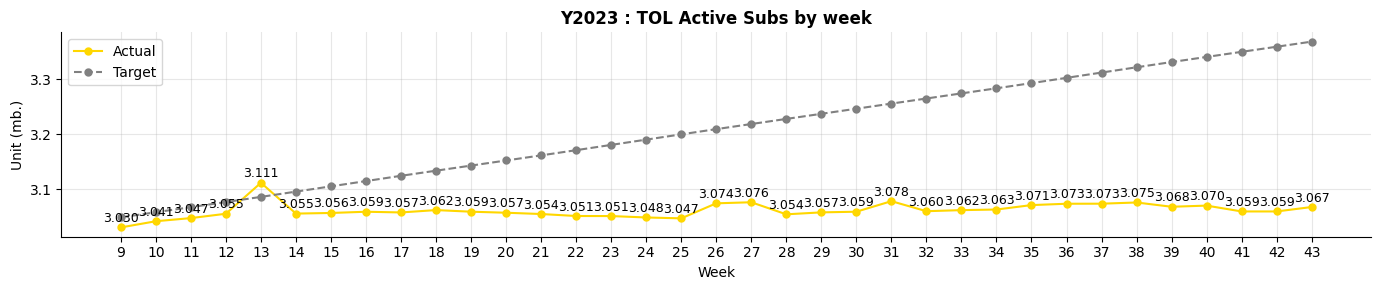

In [44]:
''' Active Subs by week '''

plt.figure(figsize=(14, 3))
plt.title(f"Y{curr_yr} : {v_product} Active Subs by week", weight='bold')

plt.plot(x_wk_axis, unit_mb(y_wk_act_actv_sub), marker='.', markeredgewidth=3, label='Actual', color='gold')
plt.plot(x_wk_axis, unit_mb(y_wk_tgt_actv_sub), marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='grey')
for i in x_wk_axis:
    plt.annotate(format(unit_mb(y_wk_act_actv_sub[i]),',.3f'), xy=(x_wk_axis[i], unit_mb(y_wk_act_actv_sub[i])+0.01), ha='center', fontsize=9)
    # plt.annotate(f"Ach:{format(y_wk_achv_actv_sub[i],',.1%')}", xy=(x_wk_axis[i], unit_mb(y_wk_act_actv_sub[i])+0.03), ha='center', fontsize=8)
    # plt.annotate(f"WoW:{format(y_wk_wow_actv_sub[i],',.1%')}", xy=(x_wk_axis[i], unit_mb(y_wk_act_actv_sub[i])+0.02), ha='center', fontsize=8)

plt.xlabel('Week')
plt.ylabel('Unit (mb.)')
plt.xticks(x_wk_axis, x_wk)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

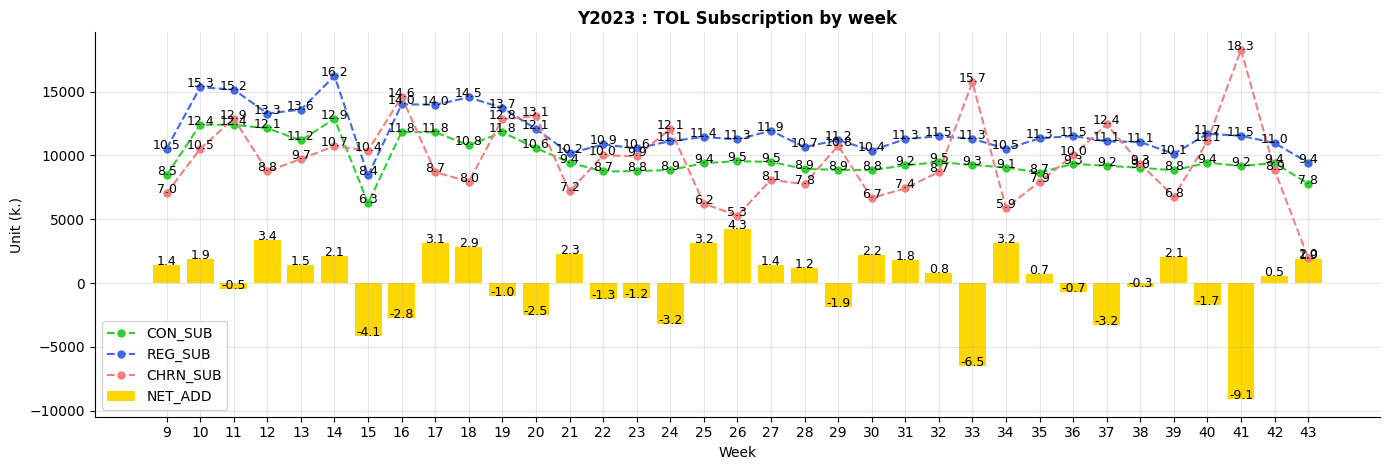

In [45]:
''' Subscription by week '''

plt.figure().set_figwidth(14)
plt.title(f"Y{curr_yr} : {v_product} Subscription by week", weight='bold')

plt.plot(x_wk_axis, y_wk_act_con_sub, marker='.', linestyle='dashed', markeredgewidth=3, label='CON_SUB', color='limegreen')
plt.plot(x_wk_axis, y_wk_act_reg_sub, marker='.', linestyle='dashed', markeredgewidth=3, label='REG_SUB', color='royalblue')
plt.plot(x_wk_axis, y_wk_act_chrn_sub, marker='.', linestyle='dashed', markeredgewidth=3, label='CHRN_SUB', color='lightcoral')
plt.bar(x_wk_axis, y_wk_act_net_add, label='NET_ADD', color='gold')
for i in x_wk_axis:
    plt.annotate(format(unit_k(y_wk_act_con_sub[i]),',.1f'), xy=(x_wk_axis[i], y_wk_act_con_sub[i]), ha='center', fontsize=9)
    plt.annotate(format(unit_k(y_wk_act_reg_sub[i]),',.1f'), xy=(x_wk_axis[i], y_wk_act_reg_sub[i]), ha='center', fontsize=9)
    plt.annotate(format(unit_k(y_wk_act_chrn_sub[i]),',.1f'), xy=(x_wk_axis[i], y_wk_act_chrn_sub[i]), ha='center', fontsize=9)
    plt.annotate(format(unit_k(y_wk_act_net_add[i]),',.1f'), xy=(x_wk_axis[i], y_wk_act_net_add[i]), ha='center', fontsize=9)

plt.xlabel('Week')
plt.ylabel('Unit (k.)')
plt.xticks(x_wk_axis, x_wk)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## ** Daily (MTD) **

### DAY : Aggregation

In [46]:
''' Create Dataframe '''

df_day_curr_mth = df_day_agg[df_day_agg['TM_KEY_MTH']==curr_mth].reset_index()

df_day_last_mth = df_day_agg[(df_day_agg['TM_KEY_MTH']==last_mth) & (df_day_agg['DAY_LABEL'].isin(df_day_curr_mth['DAY_LABEL']))][['TM_KEY_DAY', 'DAY_LABEL', 'ACT']].reset_index()

df_day_curr_mth_clean = df_day_curr_mth[df_day_curr_mth['ACT']['TOTAL'] > 0].reset_index()

df_day_curr_day = df_day_curr_mth_clean.loc[df_day_curr_mth_clean.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax()]

df_day_last_day = df_day_curr_mth_clean.shift().loc[df_day_curr_mth_clean.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax()]

In [47]:
''' DTD Values '''

''' Last Period : Values '''
last_day_rev = df_day_last_day['ACT']['TOTAL'].sum()
last_day_rev_new = df_day_last_day['ACT']['NEW'].sum()
last_day_rev_exist = df_day_last_day['ACT']['EXIST'].sum()
last_day_actv_sub = df_day_last_day['ACT']['ACTV_SUB'].sum()
last_day_con_sub = df_day_last_day['ACT']['CON_SUB'].sum()
last_day_reg_sub = df_day_last_day['ACT']['REG_SUB'].sum()
last_day_chrn_sub = df_day_last_day['ACT']['CHRN_SUB'].sum()
last_day_net_add = df_day_last_day['ACT']['NET_ADD'].sum()

''' TOTAL : Values '''
dtd_rev = df_day_curr_day['ACT']['TOTAL'].sum()
dtd_tgt = df_day_curr_day['TGT']['TOTAL'].sum()
dtd_achv = dtd_rev / dtd_tgt
dtd_last_rev = df_day_last_day['ACT']['TOTAL'].sum()
dtd_dod = (dtd_rev / dtd_last_rev) - 1
dtd_gap = dtd_rev - dtd_last_rev

''' NEW : Values '''
dtd_rev_new = df_day_curr_day['ACT']['NEW'].sum()
dtd_tgt_new = df_day_curr_day['TGT']['NEW'].sum()
dtd_achv_new = dtd_rev_new / dtd_tgt_new
dtd_last_rev_new = df_day_last_day['ACT']['NEW'].sum()
dtd_dod_new = (dtd_rev_new / dtd_last_rev_new) - 1
dtd_gap_new = dtd_rev_new - dtd_last_rev_new

''' EXIST : Values '''
dtd_rev_exist = df_day_curr_day['ACT']['EXIST'].sum()
dtd_tgt_exist = df_day_curr_day['TGT']['EXIST'].sum()
dtd_achv_exist = dtd_rev_exist / dtd_tgt_exist
dtd_last_rev_exist = df_day_last_day['ACT']['EXIST'].sum()
dtd_dod_exist = (dtd_rev_exist / dtd_last_rev_exist) - 1
dtd_gap_exist = dtd_rev_exist - dtd_last_rev_exist

''' ACTV_SUB : Values '''
dtd_actv_sub = df_day_agg[df_day_agg['TM_KEY_DAY']==curr_day]['ACT']['ACTV_SUB'].sum()
dtd_tgt_actv_sub = df_day_agg[df_day_agg['TM_KEY_DAY']==curr_day]['TGT']['ACTV_SUB'].sum()
dtd_achv_actv_sub = dtd_actv_sub / dtd_tgt_actv_sub
dtd_last_actv_sub = df_day_agg[df_day_agg['TM_KEY_DAY']==last_day]['ACT']['ACTV_SUB'].sum()
dtd_dod_actv_sub = (dtd_actv_sub / dtd_last_actv_sub) - 1
dtd_gap_actv_sub = dtd_actv_sub - dtd_last_actv_sub

''' CON_SUB : Values '''
dtd_con_sub = df_day_agg[df_day_agg['TM_KEY_DAY']==curr_day]['ACT']['CON_SUB'].sum()
dtd_tgt_con_sub = df_day_agg[df_day_agg['TM_KEY_DAY']==curr_day]['TGT']['CON_SUB'].sum()
dtd_achv_con_sub = dtd_con_sub / dtd_tgt_con_sub
dtd_last_con_sub = df_day_agg[df_day_agg['TM_KEY_DAY']==last_day]['ACT']['CON_SUB'].sum()
dtd_dod_con_sub = (dtd_con_sub / dtd_last_con_sub) - 1
dtd_gap_con_sub = dtd_con_sub - dtd_last_con_sub

''' REG_SUB : Values '''
dtd_reg_sub = df_day_agg[df_day_agg['TM_KEY_DAY']==curr_day]['ACT']['REG_SUB'].sum()
dtd_tgt_reg_sub = df_day_agg[df_day_agg['TM_KEY_DAY']==curr_day]['TGT']['REG_SUB'].sum()
dtd_achv_reg_sub = dtd_reg_sub / dtd_tgt_reg_sub
dtd_last_reg_sub = df_day_agg[df_day_agg['TM_KEY_DAY']==last_day]['ACT']['REG_SUB'].sum()
dtd_dod_reg_sub = (dtd_reg_sub / dtd_last_reg_sub) - 1
dtd_gap_reg_sub = dtd_reg_sub - dtd_last_reg_sub

''' CHRN_SUB : Values '''
dtd_chrn_sub = df_day_agg[df_day_agg['TM_KEY_DAY']==curr_day]['ACT']['CHRN_SUB'].sum()
dtd_tgt_chrn_sub = df_day_agg[df_day_agg['TM_KEY_DAY']==curr_day]['TGT']['CHRN_SUB'].sum()
dtd_achv_chrn_sub = -((dtd_chrn_sub / dtd_tgt_chrn_sub) - 1)
dtd_last_chrn_sub = df_day_agg[df_day_agg['TM_KEY_DAY']==last_day]['ACT']['CHRN_SUB'].sum()
dtd_dod_chrn_sub = (dtd_chrn_sub / dtd_last_chrn_sub) - 1
dtd_gap_chrn_sub = dtd_chrn_sub - dtd_last_chrn_sub

''' NET_ADD : Values '''
dtd_net_add = df_day_agg[df_day_agg['TM_KEY_DAY']==curr_day]['ACT']['NET_ADD'].sum()
dtd_tgt_net_add = df_day_agg[df_day_agg['TM_KEY_DAY']==curr_day]['TGT']['NET_ADD'].sum()
dtd_achv_net_add = dtd_net_add / dtd_tgt_net_add
dtd_last_net_add = df_day_agg[df_day_agg['TM_KEY_DAY']==last_day]['ACT']['NET_ADD'].sum()
dtd_dod_net_add = (dtd_net_add / dtd_last_net_add) - 1
dtd_gap_net_add = dtd_net_add - dtd_last_net_add

C:\Users\Narut4\AppData\Local\Temp\ipykernel_33120\4247804888.py:48: RuntimeWarning: invalid value encountered in scalar divide
  dtd_achv_con_sub = dtd_con_sub / dtd_tgt_con_sub
C:\Users\Narut4\AppData\Local\Temp\ipykernel_33120\4247804888.py:56: RuntimeWarning: invalid value encountered in scalar divide
  dtd_achv_reg_sub = dtd_reg_sub / dtd_tgt_reg_sub
C:\Users\Narut4\AppData\Local\Temp\ipykernel_33120\4247804888.py:64: RuntimeWarning: invalid value encountered in scalar divide
  dtd_achv_chrn_sub = -((dtd_chrn_sub / dtd_tgt_chrn_sub) - 1)
C:\Users\Narut4\AppData\Local\Temp\ipykernel_33120\4247804888.py:66: RuntimeWarning: invalid value encountered in scalar divide
  dtd_dod_chrn_sub = (dtd_chrn_sub / dtd_last_chrn_sub) - 1
C:\Users\Narut4\AppData\Local\Temp\ipykernel_33120\4247804888.py:72: RuntimeWarning: invalid value encountered in scalar divide
  dtd_achv_net_add = dtd_net_add / dtd_tgt_net_add
C:\Users\Narut4\AppData\Local\Temp\ipykernel_33120\4247804888.py:74: RuntimeWarning:

In [48]:
''' DTD BarH Dataframe'''

df_bar_h_dtd = df_day_agg[df_day_agg['TM_KEY_DAY']==curr_day]['ACT'][['CON_SUB', 'REG_SUB', 'CHRN_SUB', 'NET_ADD']].T.reset_index()
df_bar_h_dtd.columns = ['METRIC_NAME', 'VALUES']

color_conditions = [df_bar_h_dtd['METRIC_NAME']=='REG_SUB', 
                    df_bar_h_dtd['METRIC_NAME']=='CON_SUB', 
                    df_bar_h_dtd['METRIC_NAME']=='CHRN_SUB', 
                    df_bar_h_dtd['METRIC_NAME']=='NET_ADD',]
color_results = ['royalblue', 'limegreen', 'lightcoral', 'gold']
sort_results = [1, 2, 3, 4]

df_bar_h_dtd['COLOR'] = np.select(color_conditions, color_results)
df_bar_h_dtd['SORT_NO'] = np.select(color_conditions, sort_results)

df_bar_h_dtd = df_bar_h_dtd.sort_values(by='SORT_NO', ascending=False)
df_bar_h_dtd

,METRIC_NAME,VALUES,COLOR,SORT_NO
3,NET_ADD,NaN,gold,4
2,CHRN_SUB,NaN,lightcoral,3
0,CON_SUB,NaN,limegreen,2
1,REG_SUB,NaN,royalblue,1


In [49]:
''' Day Chart Values '''

x_day = df_day_curr_mth['DAY_LABEL']
x_day_axis = np.arange(len(x_day))

''' TOTAL : Values '''
y_day_act = df_day_curr_mth['ACT']['TOTAL']
y_day_tgt = df_day_curr_mth['TGT']['TOTAL']
y_day_achv = df_day_curr_mth['%ACHV']['TOTAL']
y_day_gap = df_day_curr_mth['GAP']['TOTAL']
y_day_diff = df_day_curr_mth['DIFF']['TOTAL']
y_day_last_act = df_day_last_mth['ACT']['TOTAL']
y_day_dod = df_day_curr_mth['%DOD']['TOTAL']

''' NEW : Values '''
y_day_act_new = df_day_curr_mth['ACT']['NEW']
y_day_tgt_new = df_day_curr_mth['TGT']['NEW']
y_day_achv_new = df_day_curr_mth['%ACHV']['NEW']
y_day_gap_new = df_day_curr_mth['GAP']['NEW']
y_day_diff_new = df_day_curr_mth['DIFF']['NEW']
y_day_last_act_new = df_day_last_mth['ACT']['NEW']
y_day_dod_new = df_day_curr_mth['%DOD']['NEW']

''' EXIST : Values '''
y_day_act_exist = df_day_curr_mth['ACT']['EXIST']
y_day_tgt_exist = df_day_curr_mth['TGT']['EXIST']
y_day_achv_exist = df_day_curr_mth['%ACHV']['EXIST']
y_day_gap_exist = df_day_curr_mth['GAP']['EXIST']
y_day_diff_exist = df_day_curr_mth['DIFF']['EXIST']
y_day_last_act_exist = df_day_last_mth['ACT']['EXIST']
y_day_dod_exist = df_day_curr_mth['%DOD']['EXIST']

''' ACTV_SUB : Values '''
y_day_act_actv_sub = df_day_curr_mth['ACT']['ACTV_SUB']
y_day_tgt_actv_sub = df_day_curr_mth['TGT']['ACTV_SUB']
y_day_achv_actv_sub = df_day_curr_mth['%ACHV']['ACTV_SUB']
y_day_gap_actv_sub = df_day_curr_mth['GAP']['ACTV_SUB']
y_day_diff_actv_sub = df_day_curr_mth['DIFF']['ACTV_SUB']
y_day_last_act_actv_sub = df_day_last_mth['ACT']['ACTV_SUB']
y_day_dod_actv_sub = df_day_curr_mth['%DOD']['ACTV_SUB']

''' CON_SUB : Values '''
y_day_act_con_sub = df_day_curr_mth['ACT']['CON_SUB']
y_day_tgt_con_sub = df_day_curr_mth['TGT']['CON_SUB']
y_day_achv_con_sub = df_day_curr_mth['%ACHV']['CON_SUB']
y_day_gap_con_sub = df_day_curr_mth['GAP']['CON_SUB']
y_day_diff_con_sub = df_day_curr_mth['DIFF']['CON_SUB']
y_day_last_act_con_sub = df_day_last_mth['ACT']['CON_SUB']
y_day_dod_con_sub = df_day_curr_mth['%DOD']['CON_SUB']

''' REG_SUB : Values '''
y_day_act_reg_sub = df_day_curr_mth['ACT']['REG_SUB']
y_day_tgt_reg_sub = df_day_curr_mth['TGT']['REG_SUB']
y_day_achv_reg_sub = df_day_curr_mth['%ACHV']['REG_SUB']
y_day_gap_reg_sub = df_day_curr_mth['GAP']['REG_SUB']
y_day_diff_reg_sub = df_day_curr_mth['DIFF']['REG_SUB']
y_day_last_act_reg_sub = df_day_last_mth['ACT']['REG_SUB']
y_day_dod_reg_sub = df_day_curr_mth['%DOD']['REG_SUB']

''' CHRN_SUB : Values '''
y_day_act_chrn_sub = df_day_curr_mth['ACT']['CHRN_SUB']
y_day_tgt_chrn_sub = df_day_curr_mth['TGT']['CHRN_SUB']
y_day_achv_chrn_sub = df_day_curr_mth['%ACHV']['CHRN_SUB']
y_day_gap_chrn_sub = df_day_curr_mth['GAP']['CHRN_SUB']
y_day_diff_chrn_sub = df_day_curr_mth['DIFF']['CHRN_SUB']
y_day_last_act_chrn_sub = df_day_last_mth['ACT']['CHRN_SUB']
y_day_dod_chrn_sub = df_day_curr_mth['%DOD']['CHRN_SUB']

''' NET_ADD : Values '''
y_day_act_net_add = df_day_curr_mth['ACT']['NET_ADD']
y_day_tgt_net_add = df_day_curr_mth['TGT']['NET_ADD']
y_day_achv_net_add = df_day_curr_mth['%ACHV']['NET_ADD']
y_day_gap_net_add = df_day_curr_mth['GAP']['NET_ADD']
y_day_diff_net_add = df_day_curr_mth['DIFF']['NET_ADD']
y_day_last_act_net_add = df_day_last_mth['ACT']['NET_ADD']
y_day_dod_net_add = df_day_curr_mth['%DOD']['NET_ADD']

### DAY : Visualizations

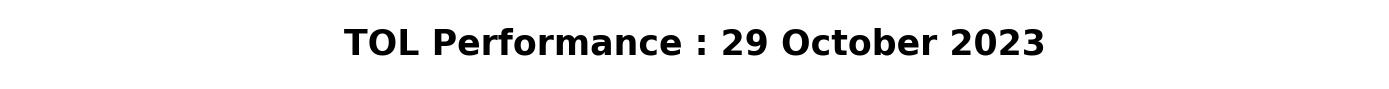

In [50]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 1)
ax1 = fig.add_subplot(gs[:, :])

ax1.text(0.5, 0.5, f"{v_product} Performance : {curr_day_label} {curr_mth_desc} {curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

fig.tight_layout()
plt.show()

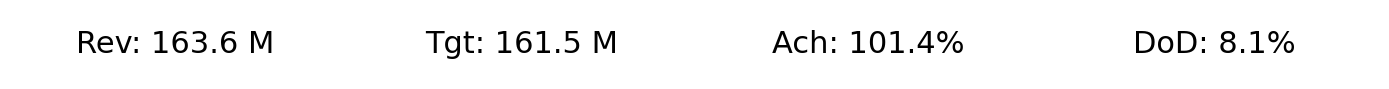

In [51]:
''' DTD Revenue '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Rev: {format(unit_mb(dtd_rev),',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(dtd_tgt),',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(dtd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"DoD: {format(dtd_dod,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

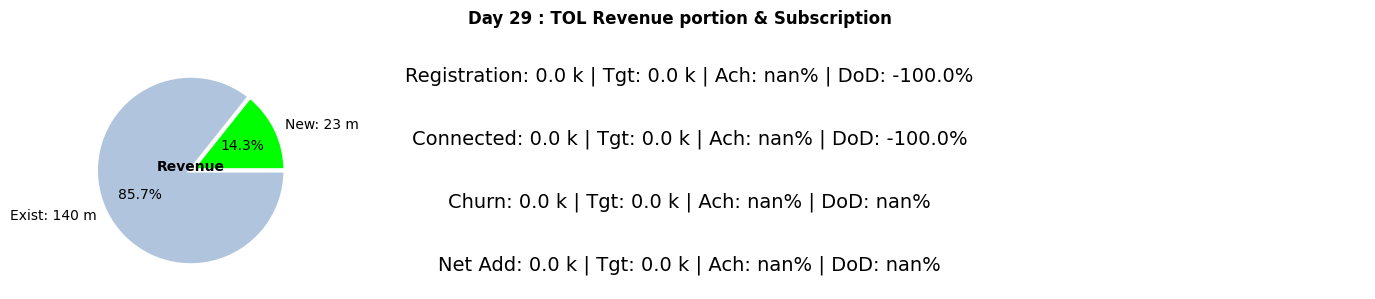

In [52]:
'''' Revenue Portion & Subscription '''

fig = plt.figure(figsize=(14, 3))
fig.suptitle(f'Day {curr_day_label} : {v_product} Revenue portion & Subscription', weight='bold')
gs = GridSpec(4, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[2, 1])
ax5 = fig.add_subplot(gs[3, 1])
ax6 = fig.add_subplot(gs[:, 2])

''' ax1 '''
y = np.array([unit_mb(dtd_rev_new.sum()), unit_mb(dtd_rev_exist.sum())])
mylabels = [f"New: {format(y[0],',.0f')} m", f"Exist: {format(y[1],',.0f')} m"]
mycolors = ["lime", "lightsteelblue"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 3, "edgecolor": "white"})
ax1.text(0, 0, 'Revenue', ha='center', fontsize=10, weight='bold')

''' ax2 '''
ax2.text(0.5, 0.5, 
         f"Registration: {format(unit_k(dtd_reg_sub),',.1f')} k | Tgt: {format(unit_k(dtd_tgt_reg_sub),',.1f')} k | Ach: {format(dtd_achv_reg_sub,',.1%')} | DoD: {format(dtd_dod_reg_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

''' ax3 '''
ax3.text(0.5, 0.5, 
         f"Connected: {format(unit_k(dtd_con_sub),',.1f')} k | Tgt: {format(unit_k(dtd_tgt_con_sub),',.1f')} k | Ach: {format(dtd_achv_con_sub,',.1%')} | DoD: {format(dtd_dod_con_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

''' ax4 '''
ax4.text(0.5, 0.5, 
         f"Churn: {format(unit_k(dtd_chrn_sub),',.1f')} k | Tgt: {format(unit_k(dtd_tgt_chrn_sub),',.1f')} k | Ach: {format(dtd_achv_chrn_sub,',.1%')} | DoD: {format(dtd_dod_chrn_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

''' ax5 '''
ax5.text(0.5, 0.5, 
         f"Net Add: {format(unit_k(dtd_net_add),',.1f')} k | Tgt: {format(unit_k(dtd_tgt_net_add),',.1f')} k | Ach: {format(dtd_achv_net_add,',.1%')} | DoD: {format(dtd_dod_net_add,',.1%')}", 
         size=14, ha='center', va='center')
ax5.spines[['top','left','right','bottom']].set_visible(False)
ax5.set_axis_off()

''' ax6 '''
bars = ax6.barh(df_bar_h_dtd['METRIC_NAME'], width=unit_k(df_bar_h_dtd['VALUES']), color=df_bar_h_dtd['COLOR'])
ax6.bar_label(bars, padding=5, fmt='%.1f k')
ax6.spines[['top','left','right','bottom']].set_visible(False)
ax6 = plt.gca()
ax6.get_xaxis().set_visible(False)
ax6.get_yaxis().set_visible(False)

fig.tight_layout()
plt.show()

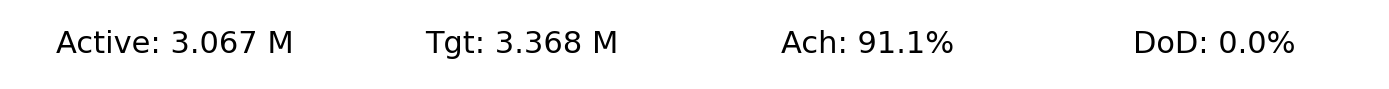

In [53]:
''' DTD Active Subs '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Active: {format(unit_mb(dtd_actv_sub),',.3f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(dtd_tgt_actv_sub),',.3f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(dtd_achv_actv_sub,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"DoD: {format(dtd_dod_actv_sub,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

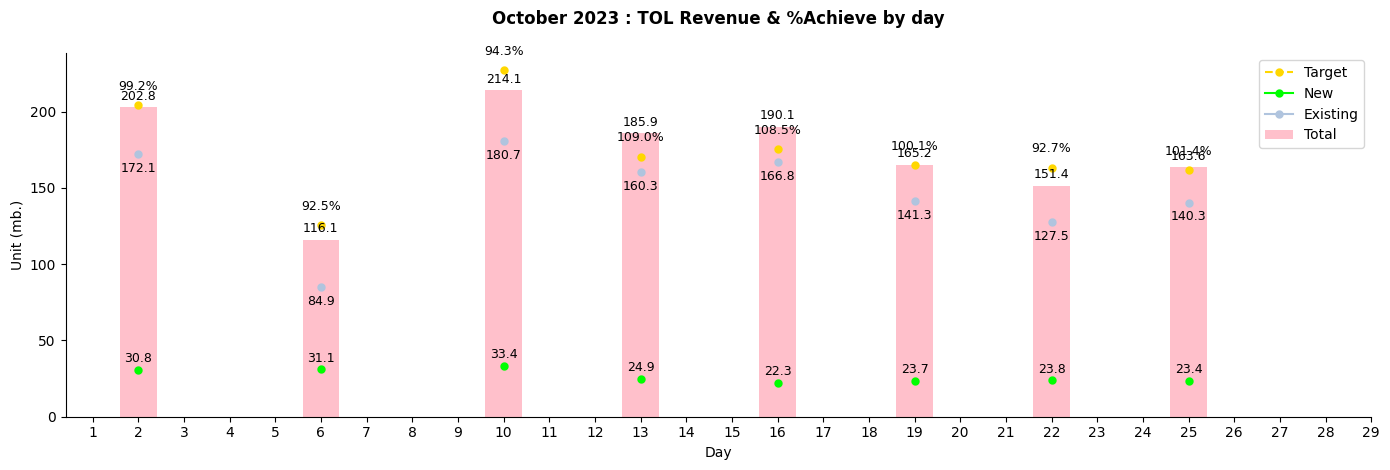

In [54]:
''' Revenue & Achieve by day '''

plt.figure().set_figwidth(14)
plt.title(f"{curr_mth_desc} {curr_yr} : {v_product} Revenue & %Achieve by day\n", weight='bold')

plt.bar(x_day_axis, unit_mb(y_day_act), label='Total', color='pink')

plt.plot(x_day_axis, unit_mb(y_day_tgt), marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
plt.plot(x_day_axis, unit_mb(y_day_act_new), marker='.', markeredgewidth=3, label='New', color='lime')
plt.plot(x_day_axis, unit_mb(y_day_act_exist), marker='.', markeredgewidth=3, label='Existing', color='lightsteelblue')

for i in x_day_axis:
    plt.annotate(format(y_day_achv[i],',.1%'), xy=(x_day_axis[i], unit_mb(y_day_tgt[i])+10), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_day_act[i]),',.1f'), xy=(x_day_axis[i], unit_mb(y_day_act[i])+5), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_day_act_new[i]),',.1f'), xy=(x_day_axis[i], unit_mb(y_day_act_new[i])+5), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_day_act_exist[i]),',.1f'), xy=(x_day_axis[i], unit_mb(y_day_act_exist[i])-5), ha='center', va='top', fontsize=9)

plt.xlabel('Day')
plt.ylabel('Unit (mb.)')
plt.xticks(x_day_axis, x_day)
plt.legend()
plt.tight_layout()
plt.show()

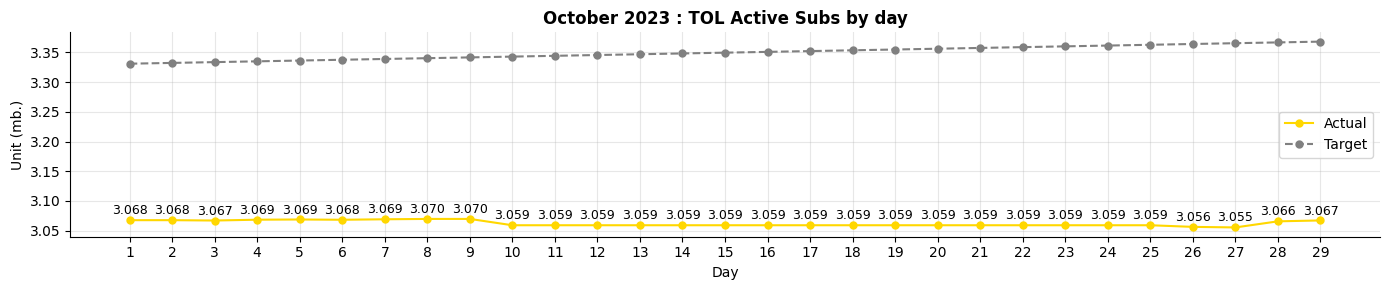

In [55]:
''' Active Subs by day '''

plt.figure(figsize=(14, 3))
plt.title(f"{curr_mth_desc} {curr_yr} : {v_product} Active Subs by day", weight='bold')

plt.plot(x_day_axis, unit_mb(y_day_act_actv_sub), marker='.', markeredgewidth=3, label='Actual', color='gold')
plt.plot(x_day_axis, unit_mb(y_day_tgt_actv_sub), marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='grey')
for i in x_day_axis:
    plt.annotate(format(unit_mb(y_day_act_actv_sub[i]),',.3f'), xy=(x_day_axis[i], unit_mb(y_day_act_actv_sub[i])+0.01), ha='center', fontsize=9)

plt.xlabel('Day')
plt.ylabel('Unit (mb.)')
plt.xticks(x_day_axis, x_day)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

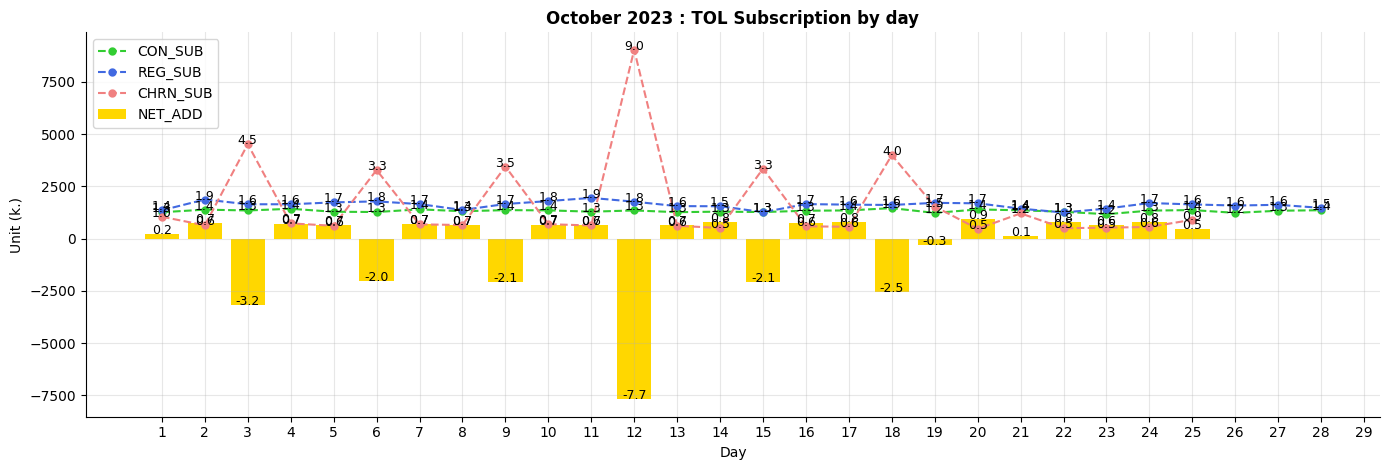

In [56]:
''' Subscription by day '''

plt.figure().set_figwidth(14)
plt.title(f"{curr_mth_desc} {curr_yr} : {v_product} Subscription by day", weight='bold')

plt.plot(x_day_axis, y_day_act_con_sub, marker='.', linestyle='dashed', markeredgewidth=3, label='CON_SUB', color='limegreen')
plt.plot(x_day_axis, y_day_act_reg_sub, marker='.', linestyle='dashed', markeredgewidth=3, label='REG_SUB', color='royalblue')
plt.plot(x_day_axis, y_day_act_chrn_sub, marker='.', linestyle='dashed', markeredgewidth=3, label='CHRN_SUB', color='lightcoral')
plt.bar(x_day_axis, y_day_act_net_add, label='NET_ADD', color='gold')
for i in x_day_axis:
    plt.annotate(format(unit_k(y_day_act_con_sub[i]),',.1f'), xy=(x_day_axis[i], y_day_act_con_sub[i]), ha='center', fontsize=9)
    plt.annotate(format(unit_k(y_day_act_reg_sub[i]),',.1f'), xy=(x_day_axis[i], y_day_act_reg_sub[i]), ha='center', fontsize=9)
    plt.annotate(format(unit_k(y_day_act_chrn_sub[i]),',.1f'), xy=(x_day_axis[i], y_day_act_chrn_sub[i]), ha='center', fontsize=9)
    plt.annotate(format(unit_k(y_day_act_net_add[i]),',.1f'), xy=(x_day_axis[i], y_day_act_net_add[i]), ha='center', fontsize=9)

plt.xlabel('Day')
plt.ylabel('Unit (k.)')
plt.xticks(x_day_axis, x_day)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()